# Borrador TFM 

In [1]:
import os
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Clase para cargar los .dat en un dataframe

In [0]:
class LoadDatFile():
  """
  This class aims to load the .dat files form UCI, and returns a
  pandas.dataframe object
  
  :inputs: folder where 
  """
  def __init__(self, folder):
      self.path = folder

  @property
  def df(self):
    ls_files = os.listdir(self.path)
    df = pd.DataFrame()
    for f in ls_files:
      path_file = os.path.join(folder, f)
      dftemp = self.proc_datfile(path_file)
      df = df.append(dftemp)
    return df

  def proc_datfile(self, path_file):
    df = pd.read_table(path_file, engine='python', sep ='\s+\d+:', header=None)
    df['Batch ID'] = self.find_batch(path_file)
    return df

  @staticmethod
  def find_batch(path_file):
    base = os.path.basename(path_file)
    name, ext = os.path.splitext(base) 
    num = re.findall(r'\d+', name)[0]
    #num = num.zfill(2)
    return int(num)

Clase para dar formato al dataframe

In [0]:
class GasDataFrame():
  
  def __init__(self, df):
    self.df = df.copy()
    df_gas = self.add_gas_info(self.df)
    self.df_gas = df_gas
  
  @staticmethod
  def add_gas_info(df):
    df[['GAS', 'CONCENTRATION']] = df.iloc[:,0].str.split(";",expand=True,)
    df.drop(df.columns[0], axis=1, inplace=True)
    df['GAS'] = df['GAS'].astype('int')
    df['CONCENTRATION'] = df['CONCENTRATION'].astype('float')
    return df

In [0]:
class DataFrameUtils:
  def __init__(self, df):
    self.df = df.copy()

  def get_crosstab(self):
    df = self.df
    return pd.crosstab(df['Batch ID'], df['GAS']).sort_index()

  def print_crosstab(self):
    tab = self.get_crosstab()
    print(tab.to_markdown())

In [57]:
folder = './drive/My Drive/data_uci/'
df = LoadDatFile(folder).df
df_gas = GasDataFrame(df).df_gas
df_gas

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,Batch ID,GAS,CONCENTRATION
0,15596.1621,1.868245,2.371604,2.803678,7.512213,-2.739388,-3.344671,-4.847512,15326.6914,1.768526,2.269085,2.713374,6.915721,-2.488324,-3.082212,-5.056975,2789.3831,2.754759,0.430440,0.649457,1.795029,-0.426662,-0.584313,-1.438976,2581.5686,2.680623,0.399746,0.605065,1.786704,-0.400115,-0.550743,-1.728611,685.3994,1.682904,0.122736,0.223703,0.584691,-0.138196,-0.236907,-0.781959,...,0.515090,1.340477,-0.361030,-0.493482,-1.200617,862.7479,1.779291,0.165138,0.246473,1.358106,-0.187465,-0.416382,-1.058061,1059.7562,1.896047,0.198946,0.334017,0.815048,-0.204467,-0.345119,-0.969336,3357.1124,3.860647,0.580818,0.806830,1.729739,-0.619214,-1.071137,-3.037772,3037.0390,3.972203,0.527291,0.728443,1.445783,-0.545079,-0.902241,-2.654529,1,1,10.0
1,26402.0704,2.532401,5.411209,6.509906,7.658469,-4.722217,-5.817651,-7.518333,23855.7812,2.164706,4.901063,5.971392,6.978131,-4.199424,-5.221090,-7.604863,3882.9057,3.155054,0.802987,1.172245,1.570895,-0.697881,-0.944655,-1.334743,3651.0427,3.130669,0.739278,1.101765,1.428631,-0.659641,-0.915543,-1.334217,982.9490,1.933877,0.233308,0.378052,0.717916,-0.225572,-0.354591,-0.748061,...,0.948781,1.369550,-0.598444,-0.820868,-1.081919,1237.0131,2.067927,0.305793,0.558008,0.948564,-0.289557,-0.501078,-1.191404,1459.6356,2.149242,0.361007,0.614619,0.950204,-0.327339,-0.503861,-0.838039,4685.7753,4.277604,1.080629,1.818559,2.237534,-1.004812,-1.530519,-1.994993,4176.4453,4.281373,0.980205,1.628050,1.951172,-0.889333,-1.323505,-1.749225,1,1,20.0
2,42103.5820,3.454189,8.198175,10.508439,11.611003,-7.668313,-9.478675,-12.230939,37562.3008,2.840403,7.386357,9.511703,12.129657,-6.689464,-8.184333,-10.196169,5476.3898,3.929721,1.132118,1.717418,2.050157,-1.052941,-1.436270,-1.956262,5140.8302,3.880357,1.054304,1.649600,1.964727,-0.995282,-1.377502,-1.844021,1409.2183,2.316449,0.335154,0.572576,0.932730,-0.337312,-0.532147,-1.011991,...,1.390353,1.810937,-0.909467,-1.254904,-1.732933,1735.0383,2.466508,0.450574,0.841068,1.808291,-0.426742,-0.711579,-1.129027,2040.1528,2.572696,0.509803,0.932630,1.248513,-0.475471,-0.730332,-1.126488,6630.1836,5.369827,1.567405,2.790448,3.279244,-1.518135,-2.384784,-2.867291,5914.6685,5.396827,1.403973,2.476956,3.039841,-1.334558,-1.993659,-2.348370,1,1,30.0
3,42825.9883,3.451192,12.113940,16.266853,39.910056,-7.849409,-9.689894,-11.921704,38379.0664,2.851173,10.840889,14.566782,39.100492,-6.878915,-8.470092,-10.739835,5670.7144,3.994661,1.587322,2.963585,2.889819,-1.116192,-1.504534,-2.159710,5343.8337,3.962529,1.479765,2.653653,2.753598,-1.061584,-1.465905,-2.027846,1499.3987,2.415714,0.476230,0.834066,1.316245,-0.373295,-0.562486,-1.005683,...,2.334433,2.427754,-0.964750,-1.315083,-1.575122,1837.0551,2.560248,0.626115,1.226975,1.828968,-0.463871,-0.785627,-1.249903,2144.8436,2.660842,0.714324,1.322181,1.883925,-0.513716,-0.777995,-1.134804,6933.2844,5.507270,2.215701,4.042550,4.675110,-1.644751,-2.607199,-3.058086,6147.4744,5.501071,1.981933,3.569823,4.049197,-1.432205,-2.146158,-2.488957,1,1,40.0
4,58151.1757,4.194839,11.455096,15.715298,17.654915,-11.083364,-13.580692,-16.407848,51975.5899,3.480866,10.409176,14.379885,15.387529,-9.543570,-11.707853,-14.370753,7483.3656,5.074172,1.576100,2.558010,3.389052,-1.515863,-2.059119,-2.494956,6995.2396,4.995555,1.474554,2.500523,2.981684,-1.436586,-2.006992,-2.424730,1976.1011,2.893531,0.480052,0.871868,1.301642,-0.487181,-0.753798,-1.628245,...,2.071232,2.683706,-1.316635,-1.798607,-3.026084,2388.1891,3.067174,0.632552,1.322201,1.666461,-0.611909,-1.018826,-1.770461,2784.4952,3.196657,0.716810,1.419936,1.845668,-0.663462,-1.022919,-1.602759,9179.2338,7.214645,2.236090,4.367815,4.946454,-2.249702,-3.594763,-4.181920,8158.6449,7.174334,1.993808,3.829303

In [7]:
df_gas[['Batch ID', 'GAS', 'CONCENTRATION']].dtypes

Batch ID           int64
GAS                int64
CONCENTRATION    float64
dtype: object

# Calculamos cuantas muestras de cada gas tenemos por Batch

In [8]:
pd.crosstab(df_gas['Batch ID'], df_gas['GAS'])

GAS,1,2,3,4,5,6
Batch ID,,,,,,
1,90,98,83,30,70,74
2,164,334,100,109,532,5
3,365,490,216,240,275,0
4,64,43,12,30,12,0
5,28,40,20,46,63,0
6,514,574,110,29,606,467
7,649,662,360,744,630,568
8,30,30,40,33,143,18
9,61,55,100,75,78,101


# Rango de concentración 

In [9]:
pivot = pd.pivot_table(df_gas, index =['GAS'], values='CONCENTRATION', aggfunc=['min', 'max', 'mean', 'std'])
pivot.round(2)

,min,max,mean,std
,CONCENTRATION,CONCENTRATION,CONCENTRATION,CONCENTRATION
GAS,,,,
1,2.5,600.0,114.95,86.64
2,2.5,300.0,116.10,79.89
3,2.5,1000.0,323.55,272.02
4,2.5,300.0,126.32,76.71
5,10.0,1000.0,228.57,217.38
6,1.0,230.0,47.66,32.58


Estos valores minimo-maximo para cada gas no corresponden a los especificados en UCI. 

> *Ammonia, Acetaldehyde, Acetone, Ethylene, Ethanol, and Toluene, dosed at a wide variety of concentration levels in the intervals (50,1000), (5,500), (12,1000), (10,300), (10,600), and (10,100) ppmv, respectively.*


In [0]:
dict_conc_interv = {
    'Amonia':      '(50,1000)',
    'Acetaldehyde':'(5,500)',
    'Acetone':     '(12,1000)',
    'Ethylene':    '(10,300)',
    'Ethanol':     '(10,600)',
    'Toluene':     '(10,100)'}

## Summarize both tables 

In [11]:
df_interv = df_gas.copy()
df_interv['range'] = df_gas.groupby('GAS')[['CONCENTRATION']].transform(lambda x: str(min(x)) +'-'+ str(max(x)) ).astype(str)
pd.crosstab(index = df_interv['Batch ID'],
            columns = [df_interv['GAS'], df_interv['range']],
            margins=True)

GAS,1,2,3,4,5,6,All
range,2.5-600.0,2.5-300.0,2.5-1000.0,2.5-300.0,10.0-1000.0,1.0-230.0,
Batch ID,,,,,,,
1,90,98,83,30,70,74,445
2,164,334,100,109,532,5,1244
3,365,490,216,240,275,0,1586
4,64,43,12,30,12,0,161
5,28,40,20,46,63,0,197
6,514,574,110,29,606,467,2300
7,649,662,360,744,630,568,3613
8,30,30,40,33,143,18,294


##Plot

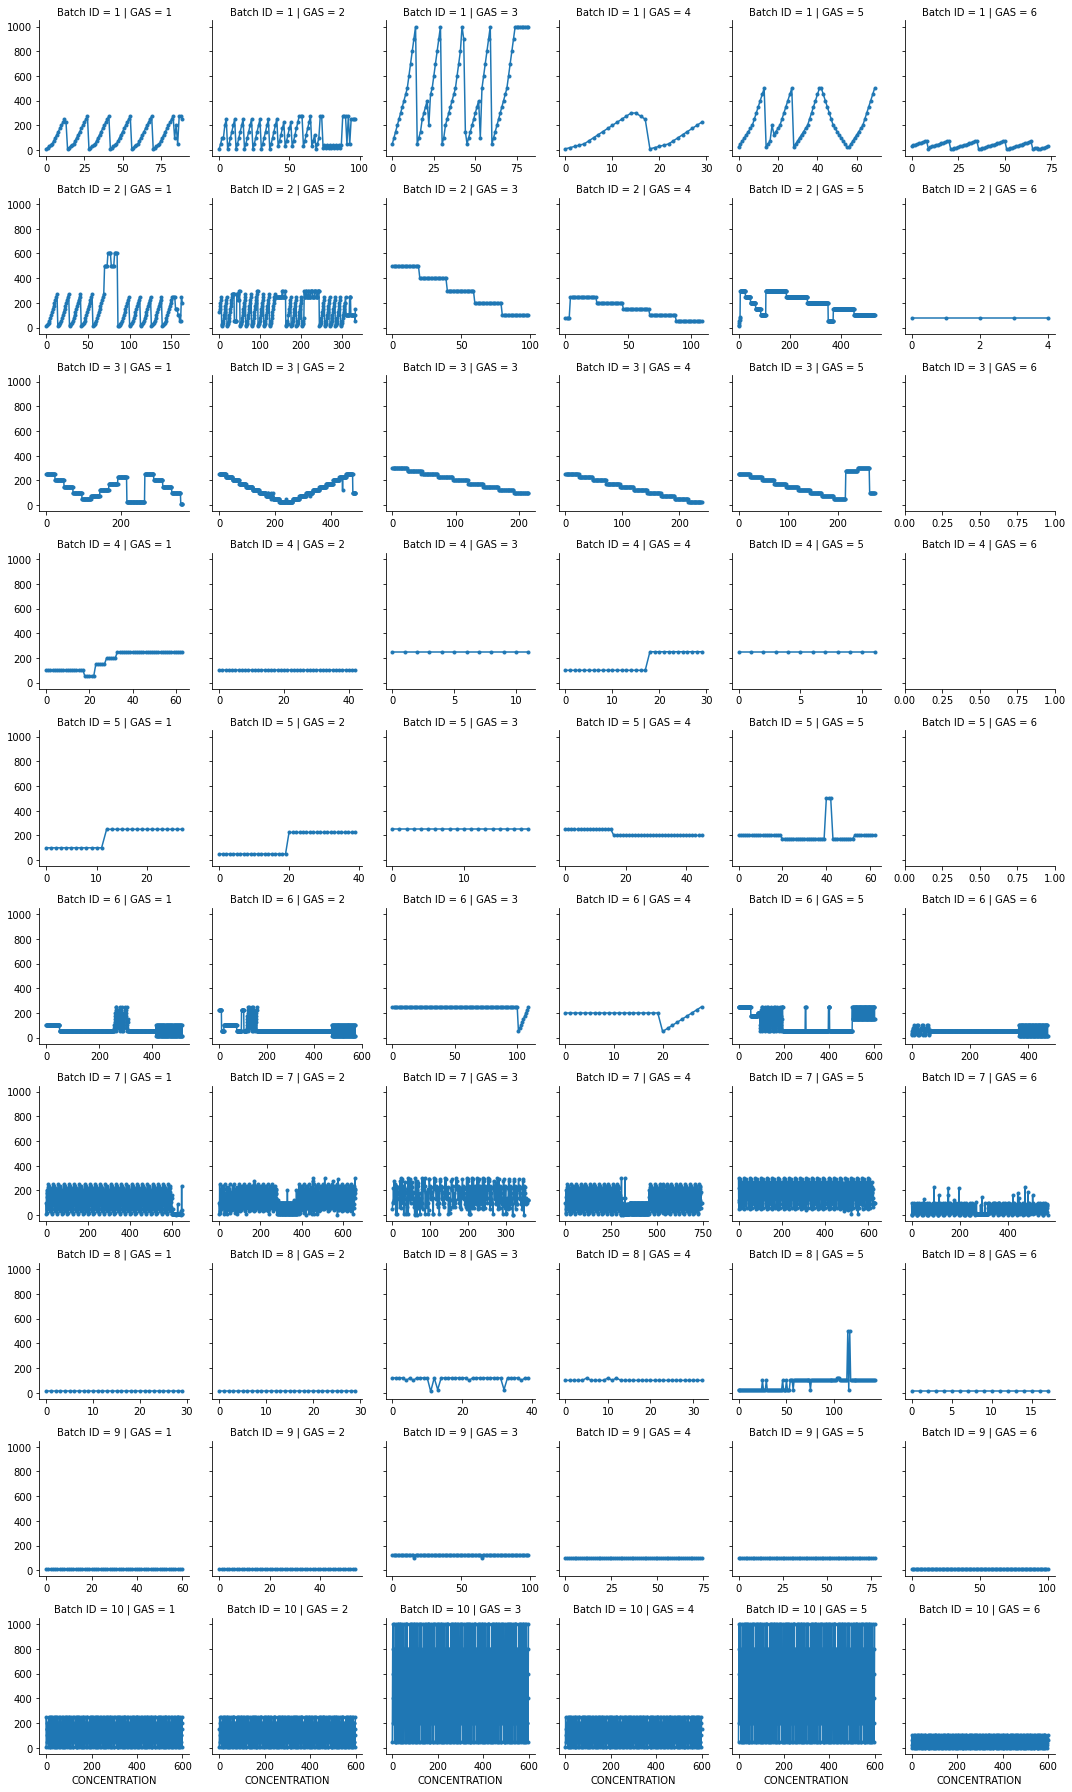

In [12]:
g = sns.FacetGrid(df_gas, col='GAS', row='Batch ID', sharex=False, height=2.5)
g = g.map(plt.plot, "CONCENTRATION", marker='.')

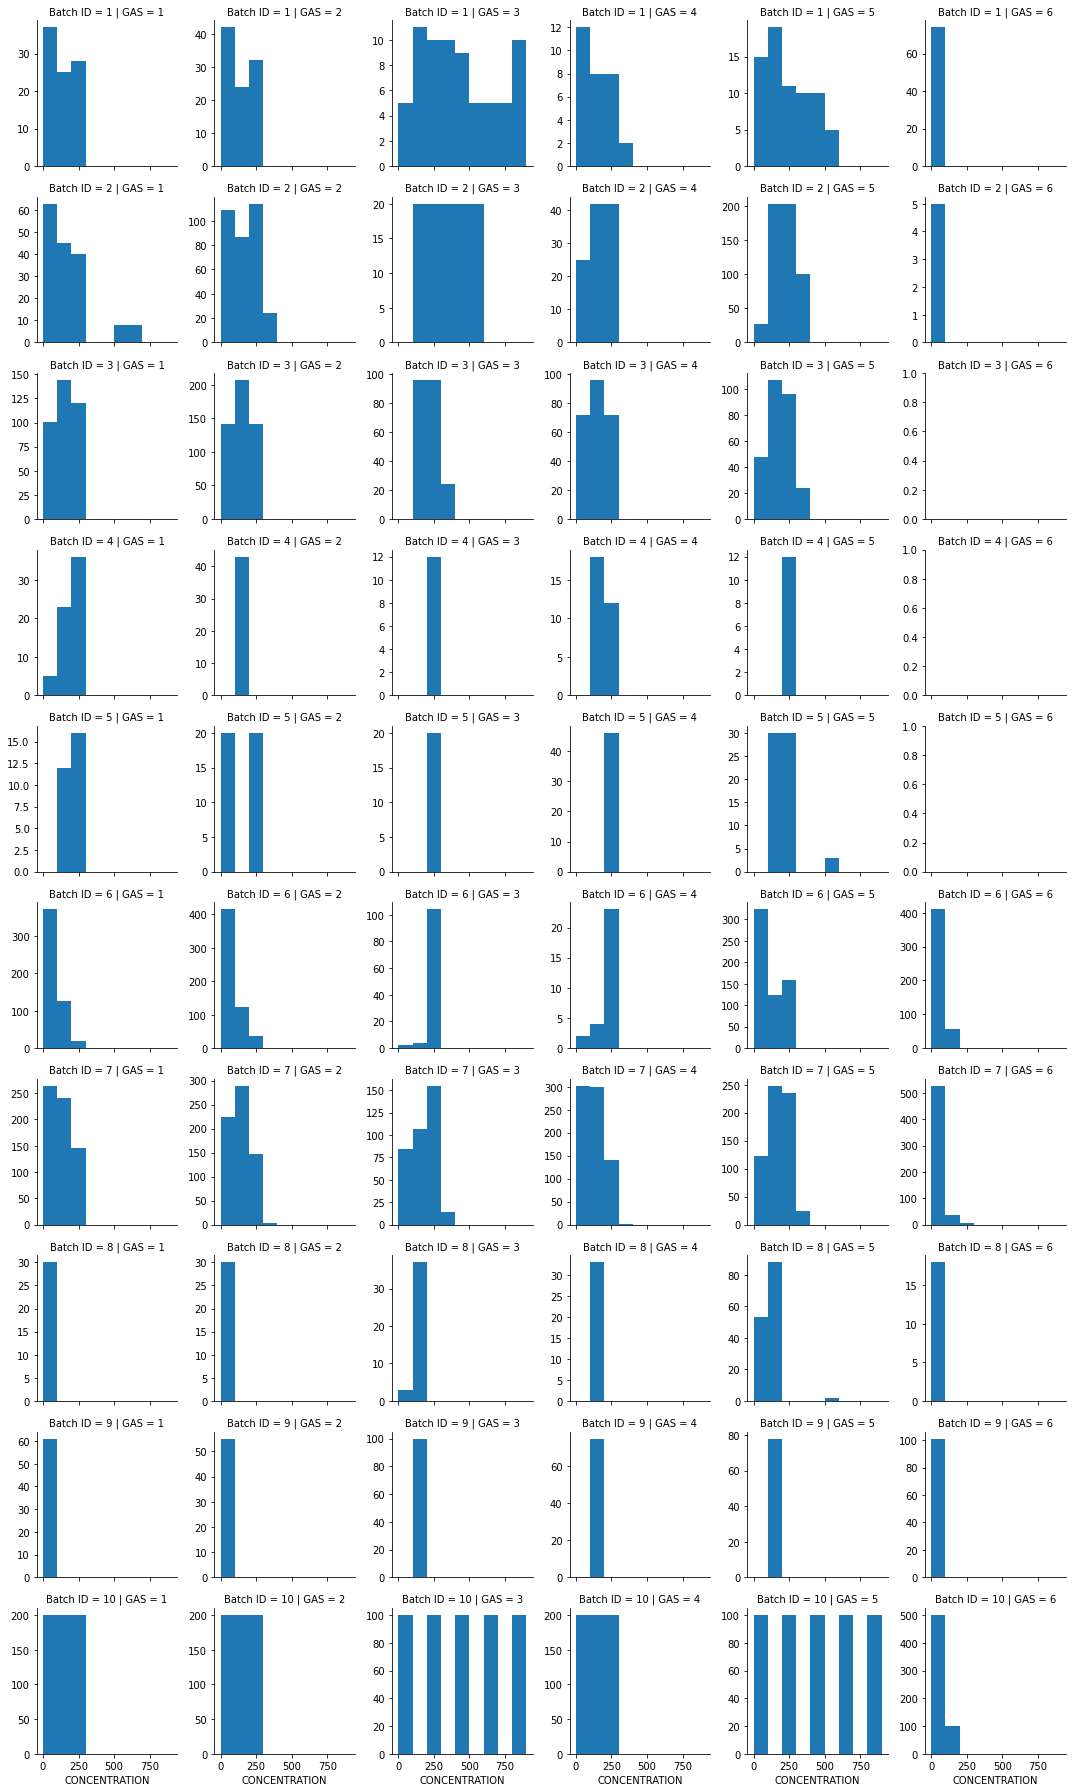

In [13]:
g = sns.FacetGrid(df_gas, col='GAS', row='Batch ID',
                  sharey=False, height=2.5)
g = g.map(plt.hist, "CONCENTRATION", bins=range(0,1000,100))

# Distribucion de gases en cada batch

## Conteo

Los datos no estan balanceados en cada Batch

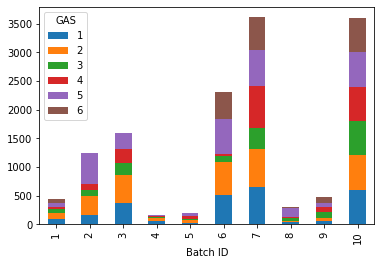

In [58]:
props = df_gas.groupby("Batch ID")['GAS'].value_counts(normalize=False).unstack()
props.plot(kind='bar', stacked='True')

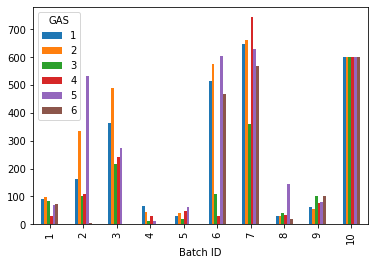

In [59]:
props.plot(kind='bar')

Podriamos elegir para entrenar los Batch01, 07, 09 y 10, ya que estan en proporcion equilibrados. 

Si realizamos un conteo vemos que el Batch 01 y 09 tienen una cantidad de muestras muy inferior a los Batch 07 y 10.  

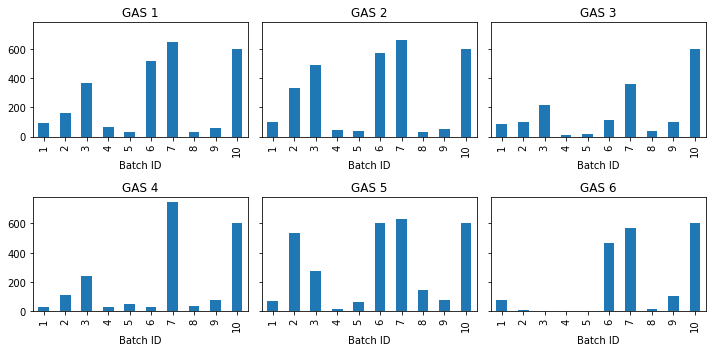

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [16]:
n = len(props.columns)
fig, axes = plt.subplots(2, n//2 , figsize=(10,5), sharey=True)
axes = axes.flatten()
for i, ax in zip(props.columns, axes):
  plt.figure()
  props[i].plot(kind='bar', ax=ax);
  ax.title.set_text('GAS ' + str(i))
fig.tight_layout()

## Proporción

En proporción, el muestreo por gas esta equilibrado, exceptuando 


*   gas6 que no aparece en los Batch 3,4,y 5
*   gas4 infrarepresentado en Batch6



GAS,1,2,3,4,5,6
Batch ID,,,,,,
1,0.202247,0.220225,0.186517,0.067416,0.157303,0.166292
2,0.131833,0.268489,0.080386,0.087621,0.427653,0.004019
3,0.230139,0.308953,0.136192,0.151324,0.173392,NaN
4,0.397516,0.267081,0.074534,0.186335,0.074534,NaN
5,0.142132,0.203046,0.101523,0.233503,0.319797,NaN
6,0.223478,0.249565,0.047826,0.012609,0.263478,0.203043
7,0.179629,0.183227,0.099640,0.205923,0.174370,0.157210
8,0.102041,0.102041,0.136054,0.112245,0.486395,0.061224
9,0.129787,0.117021,0.212766,0.159574,0.165957,0.214894


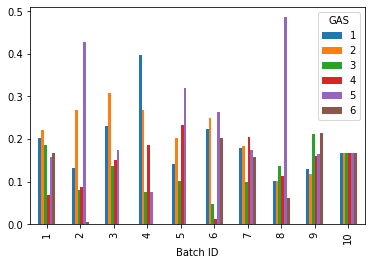

In [17]:
props = df_gas.groupby("Batch ID")['GAS'].value_counts(normalize=True).unstack()
props.plot(kind='bar')
props

# Comparacion con tablas y datos descritos en UCI

UCI especifica que: 

> *1: Ethanol; 2: Ethylene; 3: Ammonia; 4: Acetaldehyde; 5: Acetone; 6: Toluene*


In [0]:
def apply_gas_dict(df):
    """
    UCI s ays 1: Ethanol; 2: Ethylene; 3: Ammonia; 4: Acetaldehyde; 5: Acetone; 6: Toluene
    """
    df = df.copy()
    dict_gas = {'1': 'Ethanol_UCI',
                '2': 'Ethylene_UCI',
                '3': 'Ammonia_UCI',
                '4': 'Acetaldehyde_UCI',
                '5': 'Acetone_UCI',
                '6': 'Toluene_UCI'}

    dict_corregido = {'1': 'Acetone',
                      '2': 'Acetaldehyde',
                      '3': 'Ethanol',
                      '4': 'Ethylene',
                      '5': 'Ammonia',
                      '6': 'Toluene'}
    df['GAS_NAME'] = df.GAS.astype(str).replace(dict_corregido)
    return df

In [19]:
def load_uci_table():
  df = pd.DataFrame(columns = ['Batch ID',
                               'Ethanol_UCI',
                               'Ethylene_UCI',
                               'Ammonia_UCI',
                               'Acetaldehyde_UCI',
                               'Acetone_UCI',
                               'Toluene_UCI',
                               ])

  df.loc[len(df)] = ['Batch 01', 83 , 30,  70,  98,  90,   74]
  df.loc[len(df)] = ['Batch 02', 100, 109, 532, 334, 164,   5]
  df.loc[len(df)] = ['Batch 03', 216, 240, 275, 490, 365,   0]
  df.loc[len(df)] = ['Batch 04', 12 , 30,  12,  43,  64,    0]
  df.loc[len(df)] = ['Batch 05', 20 , 46,  63,  40,  28,    0]
  df.loc[len(df)] = ['Batch 06', 110, 29,  606, 574, 514, 467]
  df.loc[len(df)] = ['Batch 07', 360, 744, 630, 662, 649, 568]
  df.loc[len(df)] = ['Batch 08', 40,  33,  143, 30,  30,   18]
  df.loc[len(df)] = ['Batch 09', 100, 75,  78,  55,  61,  101]
  df.loc[len(df)] = ['Batch 10', 600, 600, 600, 600, 600, 600]
  df = df.set_index('Batch ID')
  df = df.sort_index(axis =1)
  return df

df_uci = load_uci_table()
df_uci

,Acetaldehyde_UCI,Acetone_UCI,Ammonia_UCI,Ethanol_UCI,Ethylene_UCI,Toluene_UCI
Batch ID,,,,,,
Batch 01,98,90,70,83,30,74
Batch 02,334,164,532,100,109,5
Batch 03,490,365,275,216,240,0
Batch 04,43,64,12,12,30,0
Batch 05,40,28,63,20,46,0
Batch 06,574,514,606,110,29,467
Batch 07,662,649,630,360,744,568
Batch 08,30,30,143,40,33,18
Batch 09,55,61,78,100,75,101


In [20]:
pd.crosstab(df_gas['Batch ID'], df_gas['GAS'])

GAS,1,2,3,4,5,6
Batch ID,,,,,,
1,90,98,83,30,70,74
2,164,334,100,109,532,5
3,365,490,216,240,275,0
4,64,43,12,30,12,0
5,28,40,20,46,63,0
6,514,574,110,29,606,467
7,649,662,360,744,630,568
8,30,30,40,33,143,18
9,61,55,100,75,78,101


# Series clasification

Probamos primero una red muy muy simple, que identifique qué gas es.

In [0]:
df_gas = GasDataFrame(df).df_gas
gas_X = df_gas.drop(columns = ['Batch ID', 'GAS']).to_numpy()
gas_y = df_gas['GAS'].to_numpy()

gas_X debe tener 128 columnas por cada feature + columna de concentración

In [22]:
gas_X.shape

(13910, 129)

In [23]:
gas_y.shape

(13910,)

In [0]:
X_train, X_test, y_train, y_test = train_test_split( gas_X, gas_y, test_size=0.33, random_state=42)

In [0]:
# TensorFlow and tf.keras
def gen_model_seq():
  model = keras.Sequential([
      keras.layers.Flatten(input_shape=(129,1)),
      keras.layers.Dense(64, activation='relu'),
      keras.layers.Dense(10)
  ])
  return model

In [26]:
model = gen_model_seq()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 129)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                8320      
_________________________________________________________________
dense_1 (Dense)              (None, 10)                650       
Total params: 8,970
Trainable params: 8,970
Non-trainable params: 0
_________________________________________________________________


In [0]:
def gen_and_complile_model():
  model = gen_model_seq()
  model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
  return model

model = gen_and_complile_model()

In [28]:
model.fit(X_train, y_train, epochs=30)

Epoch 1/30
292/292 [==============================] - 0s 1ms/step - loss: 530.7297 - accuracy: 0.7528
Epoch 2/30
292/292 [==============================] - 0s 1ms/step - loss: 93.7540 - accuracy: 0.8487
Epoch 3/30
292/292 [==============================] - 0s 1ms/step - loss: 78.0227 - accuracy: 0.8792
Epoch 4/30
292/292 [==============================] - 0s 1ms/step - loss: 53.2138 - accuracy: 0.9099
Epoch 5/30
292/292 [==============================] - 0s 1ms/step - loss: 53.8713 - accuracy: 0.9099
Epoch 6/30
292/292 [==============================] - 0s 1ms/step - loss: 48.8201 - accuracy: 0.9193
Epoch 7/30
292/292 [==============================] - 0s 1ms/step - loss: 50.0959 - accuracy: 0.9206
Epoch 8/30
292/292 [==============================] - 0s 1ms/step - loss: 44.8140 - accuracy: 0.9310
Epoch 9/30
292/292 [==============================] - 0s 1ms/step - loss: 41.6443 - accuracy: 0.9331
Epoch 10/30
292/292 [==============================] - 0s 1ms/step - loss: 50.6090 - accur

In [29]:
test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)
print('\nTest accuracy:', test_acc)

144/144 - 0s - loss: 21.2053 - accuracy: 0.9750

Test accuracy: 0.9749509692192078


## Utilizamos batch 1 a 9 para entrenar, y 10 para validar.

In [0]:
model.evaluate?

In [31]:
X_test.shape, y_test.shape

((4591, 129), (4591,))

In [32]:
for batch in range(1,11,1):
  df_train = df_gas[df_gas['Batch ID'] != batch]
  df_test = df_gas[df_gas['Batch ID'] == batch]

  X_train = df_train.drop(columns = ['Batch ID', 'GAS']).to_numpy()
  y_train = df_train['GAS'].to_numpy()

  X_test = df_test.drop(columns = ['Batch ID', 'GAS']).to_numpy()
  y_test = df_test['GAS'].to_numpy()

  print('Train Size:', X_train.shape, y_train.shape)
  print('Test Size:', X_test.shape, y_test.shape)

  model = gen_and_complile_model()
  model.fit(X_train, y_train, epochs=10)
  test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=0)
  print('\nTest accuracy:', test_acc, '/n')

Train Size: (13465, 129) (13465,)
Test Size: (445, 129) (445,)
Epoch 1/10
421/421 [==============================] - 1s 1ms/step - loss: 890.1250 - accuracy: 0.7234
Epoch 2/10
421/421 [==============================] - 1s 1ms/step - loss: 45.8999 - accuracy: 0.8821
Epoch 3/10
421/421 [==============================] - 1s 1ms/step - loss: 29.9606 - accuracy: 0.9134
Epoch 4/10
421/421 [==============================] - 1s 1ms/step - loss: 23.3824 - accuracy: 0.9291
Epoch 5/10
421/421 [==============================] - 1s 1ms/step - loss: 21.9654 - accuracy: 0.9317
Epoch 6/10
421/421 [==============================] - 1s 1ms/step - loss: 28.5117 - accuracy: 0.9279
Epoch 7/10
421/421 [==============================] - 1s 1ms/step - loss: 25.8699 - accuracy: 0.9319
Epoch 8/10
421/421 [==============================] - 1s 1ms/step - loss: 23.2699 - accuracy: 0.9451
Epoch 9/10
421/421 [==============================] - 1s 1ms/step - loss: 27.8271 - accuracy: 0.9349
Epoch 10/10
421/421 [======

Esto refleja que las difencia entre el ultimo batch y el resto son significativas. 

In [33]:
df_gas.groupby('Batch ID')['GAS'].count()

Batch ID
1      445
2     1244
3     1586
4      161
5      197
6     2300
7     3613
8      294
9      470
10    3600
Name: GAS, dtype: int64

In [34]:
X_test.shape

(3600, 129)

# Probamos ahora una red para predecir la concentracion de cada gas

In [0]:
df_train_reg = df_gas[df_gas['GAS'] == 1]

gas_X = df_train_reg.drop(columns = ['Batch ID', 'GAS', 'CONCENTRATION']).to_numpy()
gas_y = df_train_reg['CONCENTRATION'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split( gas_X, gas_y, test_size=0.33, random_state=42)

In [38]:
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error 
from matplotlib import pyplot as plt
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings 
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)
from xgboost import XGBRegressor


NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(128, kernel_initializer='normal',input_dim = X_train.shape[1], activation='relu'))

# The Hidden Layers :
NN_model.add(Dense(128, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(128, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(128, kernel_initializer='normal',activation='relu'))

# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
NN_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_7 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_8 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_9 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 129       
Total params: 66,177
Trainable params: 66,177
Non-trainable params: 0
_________________________________________________________________


In [0]:
checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

In [40]:
NN_model.fit(X_train, y_train, epochs=500, batch_size=32, validation_split = 0.2, callbacks=callbacks_list)

Train on 1374 samples, validate on 344 samples
Epoch 1/500
1374/1374 [==============================] - 0s 179us/step - loss: 44.7740 - mean_absolute_error: 44.7740 - val_loss: 27.4497 - val_mean_absolute_error: 27.4497

Epoch 00001: val_loss improved from inf to 27.44971, saving model to Weights-001--27.44971.hdf5
Epoch 2/500
1374/1374 [==============================] - 0s 69us/step - loss: 37.1102 - mean_absolute_error: 37.1102 - val_loss: 36.2748 - val_mean_absolute_error: 36.2748

Epoch 00002: val_loss did not improve from 27.44971
Epoch 3/500
1374/1374 [==============================] - 0s 68us/step - loss: 31.2540 - mean_absolute_error: 31.2540 - val_loss: 24.6900 - val_mean_absolute_error: 24.6900

Epoch 00003: val_loss improved from 27.44971 to 24.68999, saving model to Weights-003--24.68999.hdf5
Epoch 4/500
1374/1374 [==============================] - 0s 69us/step - loss: 27.0987 - mean_absolute_error: 27.0987 - val_loss: 24.6940 - val_mean_absolute_error: 24.6940

Epoch 00004

In [0]:
weights_file = 'Weights-465--5.27816.hdf5' # choose the best checkpoint 
NN_model.load_weights(weights_file) # load it
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['accuracy'])

In [48]:
test_loss, test_acc = NN_model.evaluate(X_test,  y_test, verbose=2)
test_loss, test_acc

(21.795207506650453, 0.1652892529964447)

Tengo que investigar, no entiendo muy bien esta red, no me cuadra ese valor de accuracy, es peor que el azar. 

# Crear n categorias, para cada pareja gas concentracion

In [51]:
folder = './drive/My Drive/data_uci/'
df = LoadDatFile(folder).df
df_gas = GasDataFrame(df).df_gas
df_gas

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,Batch ID,GAS,CONCENTRATION
0,15596.1621,1.868245,2.371604,2.803678,7.512213,-2.739388,-3.344671,-4.847512,15326.6914,1.768526,2.269085,2.713374,6.915721,-2.488324,-3.082212,-5.056975,2789.3831,2.754759,0.430440,0.649457,1.795029,-0.426662,-0.584313,-1.438976,2581.5686,2.680623,0.399746,0.605065,1.786704,-0.400115,-0.550743,-1.728611,685.3994,1.682904,0.122736,0.223703,0.584691,-0.138196,-0.236907,-0.781959,...,0.515090,1.340477,-0.361030,-0.493482,-1.200617,862.7479,1.779291,0.165138,0.246473,1.358106,-0.187465,-0.416382,-1.058061,1059.7562,1.896047,0.198946,0.334017,0.815048,-0.204467,-0.345119,-0.969336,3357.1124,3.860647,0.580818,0.806830,1.729739,-0.619214,-1.071137,-3.037772,3037.0390,3.972203,0.527291,0.728443,1.445783,-0.545079,-0.902241,-2.654529,1,1,10.0
1,26402.0704,2.532401,5.411209,6.509906,7.658469,-4.722217,-5.817651,-7.518333,23855.7812,2.164706,4.901063,5.971392,6.978131,-4.199424,-5.221090,-7.604863,3882.9057,3.155054,0.802987,1.172245,1.570895,-0.697881,-0.944655,-1.334743,3651.0427,3.130669,0.739278,1.101765,1.428631,-0.659641,-0.915543,-1.334217,982.9490,1.933877,0.233308,0.378052,0.717916,-0.225572,-0.354591,-0.748061,...,0.948781,1.369550,-0.598444,-0.820868,-1.081919,1237.0131,2.067927,0.305793,0.558008,0.948564,-0.289557,-0.501078,-1.191404,1459.6356,2.149242,0.361007,0.614619,0.950204,-0.327339,-0.503861,-0.838039,4685.7753,4.277604,1.080629,1.818559,2.237534,-1.004812,-1.530519,-1.994993,4176.4453,4.281373,0.980205,1.628050,1.951172,-0.889333,-1.323505,-1.749225,1,1,20.0
2,42103.5820,3.454189,8.198175,10.508439,11.611003,-7.668313,-9.478675,-12.230939,37562.3008,2.840403,7.386357,9.511703,12.129657,-6.689464,-8.184333,-10.196169,5476.3898,3.929721,1.132118,1.717418,2.050157,-1.052941,-1.436270,-1.956262,5140.8302,3.880357,1.054304,1.649600,1.964727,-0.995282,-1.377502,-1.844021,1409.2183,2.316449,0.335154,0.572576,0.932730,-0.337312,-0.532147,-1.011991,...,1.390353,1.810937,-0.909467,-1.254904,-1.732933,1735.0383,2.466508,0.450574,0.841068,1.808291,-0.426742,-0.711579,-1.129027,2040.1528,2.572696,0.509803,0.932630,1.248513,-0.475471,-0.730332,-1.126488,6630.1836,5.369827,1.567405,2.790448,3.279244,-1.518135,-2.384784,-2.867291,5914.6685,5.396827,1.403973,2.476956,3.039841,-1.334558,-1.993659,-2.348370,1,1,30.0
3,42825.9883,3.451192,12.113940,16.266853,39.910056,-7.849409,-9.689894,-11.921704,38379.0664,2.851173,10.840889,14.566782,39.100492,-6.878915,-8.470092,-10.739835,5670.7144,3.994661,1.587322,2.963585,2.889819,-1.116192,-1.504534,-2.159710,5343.8337,3.962529,1.479765,2.653653,2.753598,-1.061584,-1.465905,-2.027846,1499.3987,2.415714,0.476230,0.834066,1.316245,-0.373295,-0.562486,-1.005683,...,2.334433,2.427754,-0.964750,-1.315083,-1.575122,1837.0551,2.560248,0.626115,1.226975,1.828968,-0.463871,-0.785627,-1.249903,2144.8436,2.660842,0.714324,1.322181,1.883925,-0.513716,-0.777995,-1.134804,6933.2844,5.507270,2.215701,4.042550,4.675110,-1.644751,-2.607199,-3.058086,6147.4744,5.501071,1.981933,3.569823,4.049197,-1.432205,-2.146158,-2.488957,1,1,40.0
4,58151.1757,4.194839,11.455096,15.715298,17.654915,-11.083364,-13.580692,-16.407848,51975.5899,3.480866,10.409176,14.379885,15.387529,-9.543570,-11.707853,-14.370753,7483.3656,5.074172,1.576100,2.558010,3.389052,-1.515863,-2.059119,-2.494956,6995.2396,4.995555,1.474554,2.500523,2.981684,-1.436586,-2.006992,-2.424730,1976.1011,2.893531,0.480052,0.871868,1.301642,-0.487181,-0.753798,-1.628245,...,2.071232,2.683706,-1.316635,-1.798607,-3.026084,2388.1891,3.067174,0.632552,1.322201,1.666461,-0.611909,-1.018826,-1.770461,2784.4952,3.196657,0.716810,1.419936,1.845668,-0.663462,-1.022919,-1.602759,9179.2338,7.214645,2.236090,4.367815,4.946454,-2.249702,-3.594763,-4.181920,8158.6449,7.174334,1.993808,3.829303

In [0]:
df_gas_1 = df_gas[df_gas['GAS'] == 1]
df_net = df_gas.drop(columns = 'GAS')

df_train = df_net[df_net['Batch ID'] != 'Batch 09']
df_test  = df_net[df_net['Batch ID'] == 'Batch 09']

df_train = df_train.drop(columns = 'Batch ID')
df_test  = df_test.drop(columns = 'Batch ID')

X_tr = df_train.drop(columns = 'CONCENTRATION')
y_tr = df_train['CONCENTRATION']

X_test = df_test.drop(columns = 'CONCENTRATION')
y_test = df_test['CONCENTRATION']

In [53]:
X_tr

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128
0,15596.1621,1.868245,2.371604,2.803678,7.512213,-2.739388,-3.344671,-4.847512,15326.6914,1.768526,2.269085,2.713374,6.915721,-2.488324,-3.082212,-5.056975,2789.3831,2.754759,0.430440,0.649457,1.795029,-0.426662,-0.584313,-1.438976,2581.5686,2.680623,0.399746,0.605065,1.786704,-0.400115,-0.550743,-1.728611,685.3994,1.682904,0.122736,0.223703,0.584691,-0.138196,-0.236907,-0.781959,...,2185.9741,2.949381,0.342575,0.515090,1.340477,-0.361030,-0.493482,-1.200617,862.7479,1.779291,0.165138,0.246473,1.358106,-0.187465,-0.416382,-1.058061,1059.7562,1.896047,0.198946,0.334017,0.815048,-0.204467,-0.345119,-0.969336,3357.1124,3.860647,0.580818,0.806830,1.729739,-0.619214,-1.071137,-3.037772,3037.0390,3.972203,0.527291,0.728443,1.445783,-0.545079,-0.902241,-2.654529
1,26402.0704,2.532401,5.411209,6.509906,7.658469,-4.722217,-5.817651,-7.518333,23855.7812,2.164706,4.901063,5.971392,6.978131,-4.199424,-5.221090,-7.604863,3882.9057,3.155054,0.802987,1.172245,1.570895,-0.697881,-0.944655,-1.334743,3651.0427,3.130669,0.739278,1.101765,1.428631,-0.659641,-0.915543,-1.334217,982.9490,1.933877,0.233308,0.378052,0.717916,-0.225572,-0.354591,-0.748061,...,3079.0621,3.399659,0.649639,0.948781,1.369550,-0.598444,-0.820868,-1.081919,1237.0131,2.067927,0.305793,0.558008,0.948564,-0.289557,-0.501078,-1.191404,1459.6356,2.149242,0.361007,0.614619,0.950204,-0.327339,-0.503861,-0.838039,4685.7753,4.277604,1.080629,1.818559,2.237534,-1.004812,-1.530519,-1.994993,4176.4453,4.281373,0.980205,1.628050,1.951172,-0.889333,-1.323505,-1.749225
2,42103.5820,3.454189,8.198175,10.508439,11.611003,-7.668313,-9.478675,-12.230939,37562.3008,2.840403,7.386357,9.511703,12.129657,-6.689464,-8.184333,-10.196169,5476.3898,3.929721,1.132118,1.717418,2.050157,-1.052941,-1.436270,-1.956262,5140.8302,3.880357,1.054304,1.649600,1.964727,-0.995282,-1.377502,-1.844021,1409.2183,2.316449,0.335154,0.572576,0.932730,-0.337312,-0.532147,-1.011991,...,4409.1721,4.286887,0.917809,1.390353,1.810937,-0.909467,-1.254904,-1.732933,1735.0383,2.466508,0.450574,0.841068,1.808291,-0.426742,-0.711579,-1.129027,2040.1528,2.572696,0.509803,0.932630,1.248513,-0.475471,-0.730332,-1.126488,6630.1836,5.369827,1.567405,2.790448,3.279244,-1.518135,-2.384784,-2.867291,5914.6685,5.396827,1.403973,2.476956,3.039841,-1.334558,-1.993659,-2.348370
3,42825.9883,3.451192,12.113940,16.266853,39.910056,-7.849409,-9.689894,-11.921704,38379.0664,2.851173,10.840889,14.566782,39.100492,-6.878915,-8.470092,-10.739835,5670.7144,3.994661,1.587322,2.963585,2.889819,-1.116192,-1.504534,-2.159710,5343.8337,3.962529,1.479765,2.653653,2.753598,-1.061584,-1.465905,-2.027846,1499.3987,2.415714,0.476230,0.834066,1.316245,-0.373295,-0.562486,-1.005683,...,4570.3443,4.382205,1.298156,2.334433,2.427754,-0.964750,-1.315083,-1.575122,1837.0551,2.560248,0.626115,1.226975,1.828968,-0.463871,-0.785627,-1.249903,2144.8436,2.660842,0.714324,1.322181,1.883925,-0.513716,-0.777995,-1.134804,6933.2844,5.507270,2.215701,4.042550,4.675110,-1.644751,-2.607199,-3.058086,6147.4744,5.501071,1.981933,3.569823,4.049197,-1.432205,-2.146158,-2.488957
4,58151.1757,4.194839,11.455096,15.715298,17.654915,-11.083364,-13.580692,-16.407848,51975.5899,3.480866,10.409176,14.379885,15.387529,-9.543570,-11.707853,-14.370753,7483.3656,5.074172,1.576100,2.558010,3.389052,-1.515863,-2.059119,-2.494956,6995.2396,4.995555,1.474554,2.500523,2.981684,-1.436586,-2.006992,-2.424730,1976.1011,2.893531,0.480052,0.871868,1.301642,-0.487181,-0.753798,-1.628245,...,6086.2545,5.642596,1.293397,2.071232,2.683706,-1.316635,-1.798607,-3.026084,2388.1891,3.067174,0.632552,1.322201,1.666461,-0.611909,-1.018826,-1.770461,2784.4952,3.196657,0.716810,1.419936,1.845668,-0.663462,-1.022919,-1.602759,9179.2338,7.214645,2.23609

In [60]:
 model = keras.Sequential([
      keras.layers.Flatten(input_shape=(128,1)),
      keras.layers.Dense(128, activation='relu'),
      keras.layers.Dense(1)
  ])
 
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['accuracy'])
#model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#              optimizer='adam',
#              metrics=['mean_absolute_error'])

model.fit(X_tr, y_tr, epochs=30)

Epoch 1/30
435/435 [==============================] - 1s 1ms/step - loss: 532.0547 - accuracy: 0.0028
Epoch 2/30
435/435 [==============================] - 1s 1ms/step - loss: 258.0534 - accuracy: 0.0034
Epoch 3/30
435/435 [==============================] - 1s 1ms/step - loss: 194.3401 - accuracy: 0.0039
Epoch 4/30
435/435 [==============================] - 1s 1ms/step - loss: 193.1693 - accuracy: 0.0040
Epoch 5/30
435/435 [==============================] - 1s 1ms/step - loss: 204.1605 - accuracy: 0.0027
Epoch 6/30
435/435 [==============================] - 1s 1ms/step - loss: 171.5872 - accuracy: 0.0028
Epoch 7/30
435/435 [==============================] - 1s 1ms/step - loss: 195.1407 - accuracy: 0.0040
Epoch 8/30
435/435 [==============================] - 1s 1ms/step - loss: 163.2994 - accuracy: 0.0032
Epoch 9/30
435/435 [==============================] - 1s 1ms/step - loss: 174.5983 - accuracy: 0.0037
Epoch 10/30
435/435 [==============================] - 1s 1ms/step - loss: 167.241

In [61]:
test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)
print('\nTest accuracy:', test_acc)

AttributeError: ignored

No es viable

In [62]:
regressor = LinearRegression()  
regressor.fit(X_tr, y_tr)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [63]:
coeff_df = pd.DataFrame(regressor.coef_, X_tr.columns, columns=['Coefficient'])  
coeff_df

,Coefficient
1,0.000522
2,0.706375
3,-4.081963
4,0.859733
5,-0.037980
...,...
124,-11.005861
125,-0.875119
126,-24.120533
127,4.067758


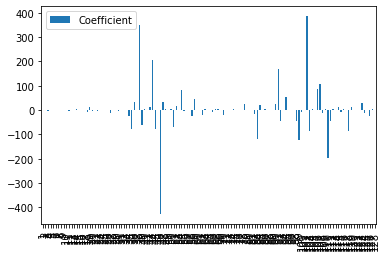

In [64]:
coeff_df.plot.bar()

In [65]:
y_pred = regressor.predict(X_test)
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df1 = df.head(25)

ValueError: ignored

In [0]:
df1.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [0]:
y_test.unique()

In [0]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

# RandomForest


In [0]:
# load dataset
df = LoadDatFile(folder).df
df_gas = GasDataFrame(df).df_gas

In [0]:
df_gas_1 = df_gas[df_gas['GAS']==1]

df_tr = df_gas_1[df_gas_1['Batch ID'] <= 8 ]
df_test = df_gas_1[df_gas_1['Batch ID'] == 9 ]

df_tr = df_tr.drop(columns = ['GAS', 'Batch ID'])
df_test = df_test.drop(columns = ['GAS', 'Batch ID'])

X_tr = df_tr.drop(columns = ['CONCENTRATION'])
X_test = df_test.drop(columns = ['CONCENTRATION'])

y_tr = df_tr['CONCENTRATION']
y_test = df_test['CONCENTRATION']

In [67]:
regr = RandomForestRegressor(max_depth=2, random_state=0)
regr.fit(X_tr, y_tr)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=2, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [68]:
regr.score(X_tr, y_tr)

0.8219579063531003

In [0]:
y_pred = regressor.predict(X_test)
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df1 = df.head(25)

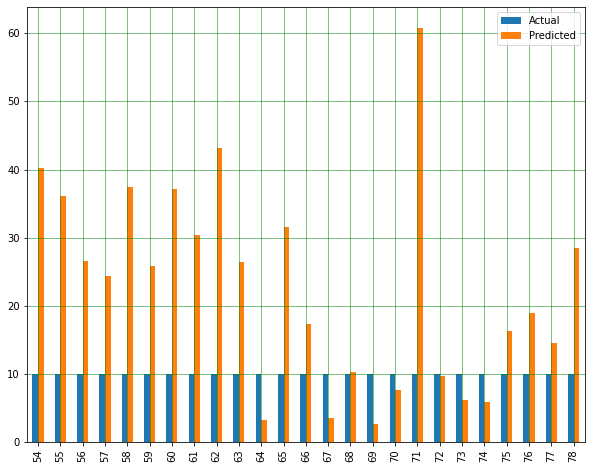

In [70]:
df1.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

# Vamos a ver las señales 

In [0]:
df = LoadDatFile(folder).df
df_gas = GasDataFrame(df).df
df_gas_1 = df_gas[df_gas['GAS']==2]
df_signal = df_gas_1.drop(columns = ['GAS', 'Batch ID'])

In [73]:
np.sort(df_signal['CONCENTRATION'].unique())

array([  2.5,   5. ,  10. ,  20. ,  25. ,  30. ,  40. ,  50. ,  55. ,
        60. ,  70. ,  75. ,  80. ,  85. ,  90. , 100. , 110. , 120. ,
       125. , 130. , 140. , 150. , 160. , 170. , 175. , 180. , 190. ,
       200. , 210. , 220. , 225. , 230. , 240. , 250. , 275. , 280. ,
       290. , 300. ])

<Figure size 432x288 with 0 Axes>

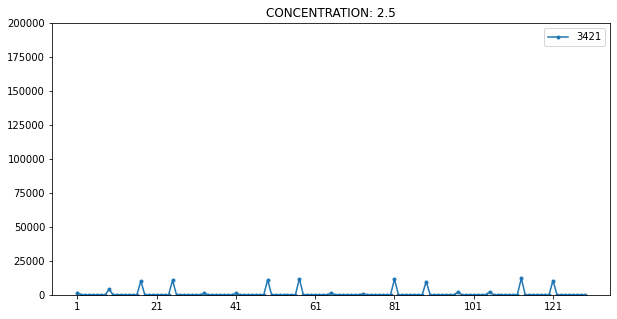

<Figure size 432x288 with 0 Axes>

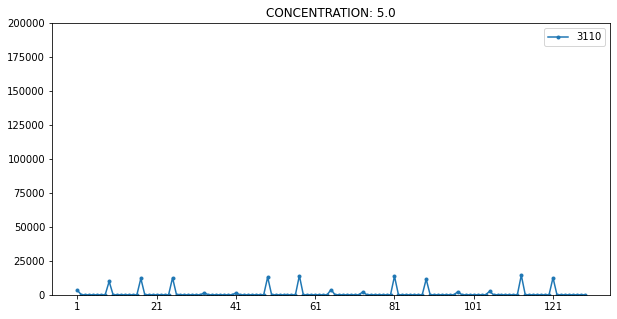

<Figure size 432x288 with 0 Axes>

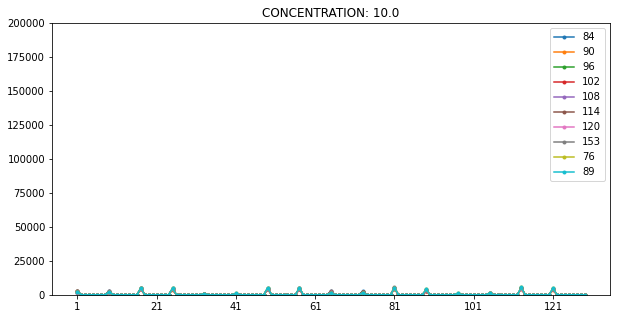

<Figure size 432x288 with 0 Axes>

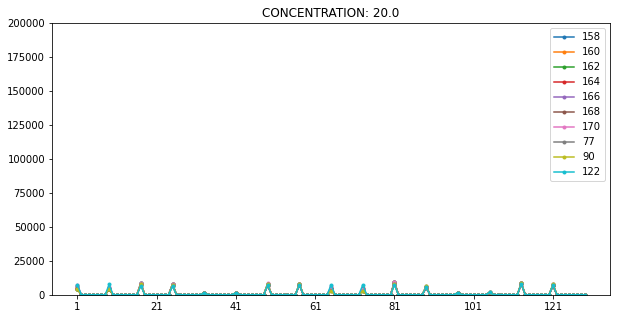

<Figure size 432x288 with 0 Axes>

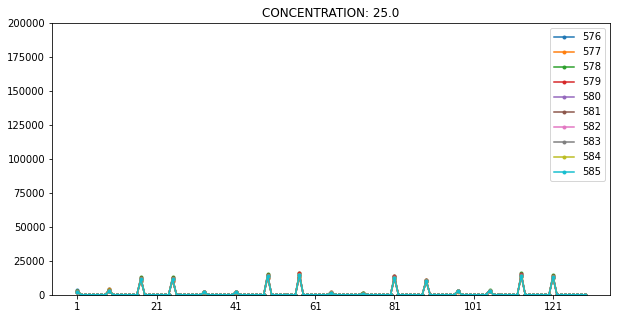

<Figure size 432x288 with 0 Axes>

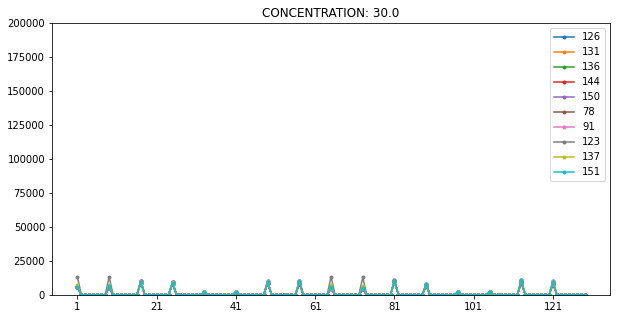

<Figure size 432x288 with 0 Axes>

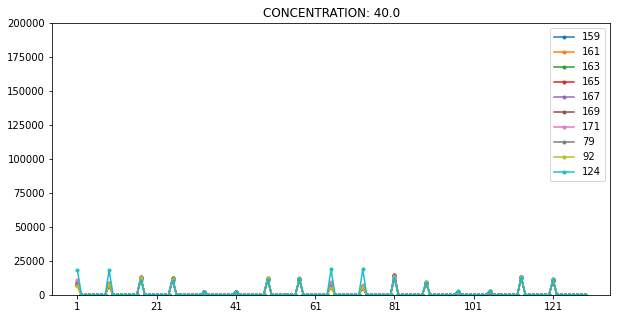

<Figure size 432x288 with 0 Axes>

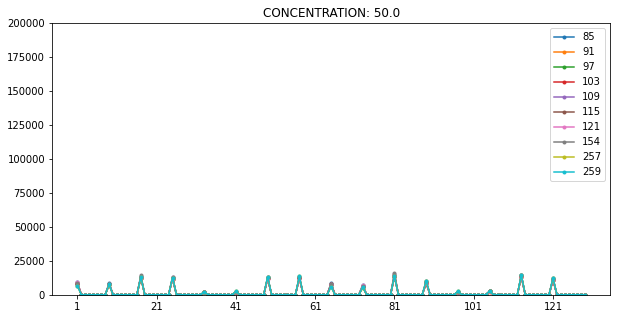

<Figure size 432x288 with 0 Axes>

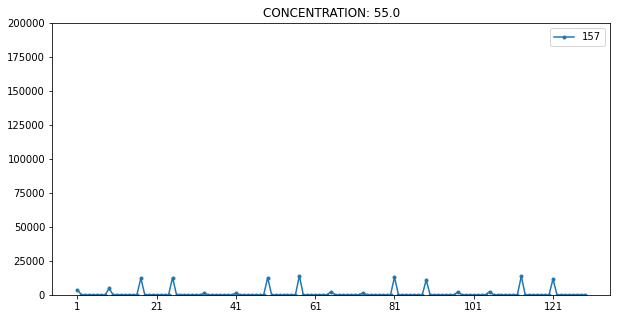

<Figure size 432x288 with 0 Axes>

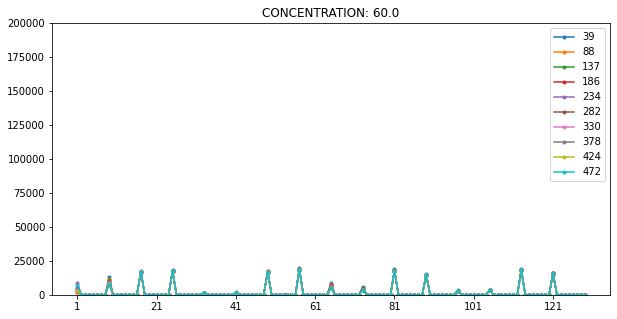

<Figure size 432x288 with 0 Axes>

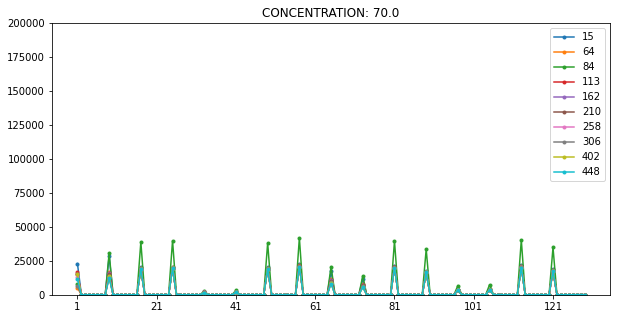

<Figure size 432x288 with 0 Axes>

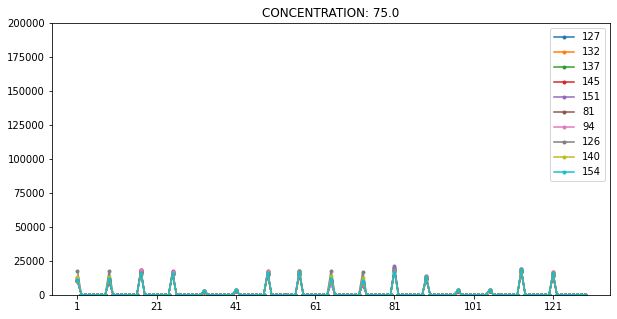

<Figure size 432x288 with 0 Axes>

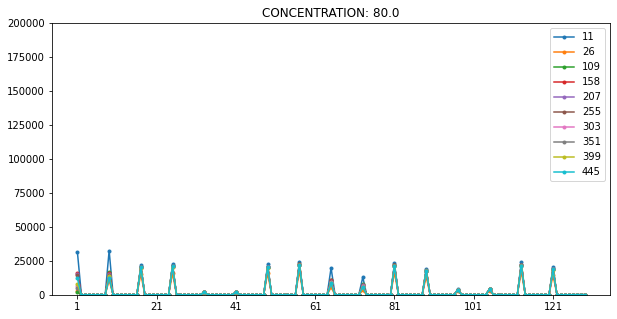

<Figure size 432x288 with 0 Axes>

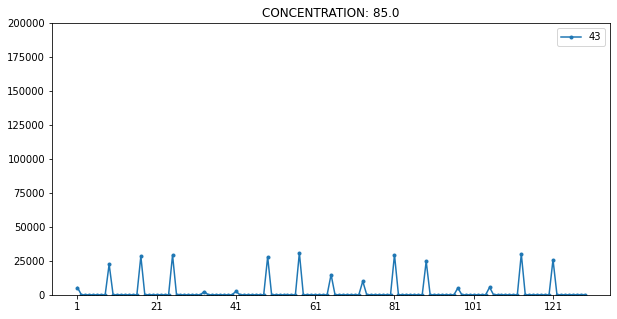

<Figure size 432x288 with 0 Axes>

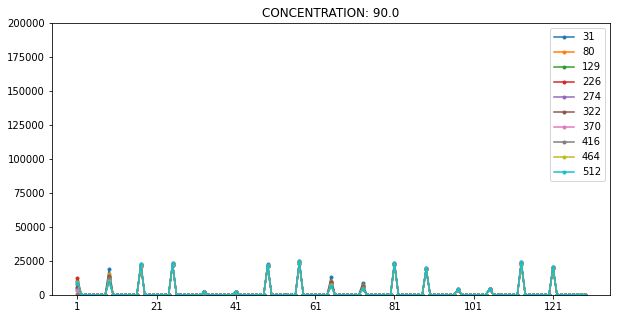

<Figure size 432x288 with 0 Axes>

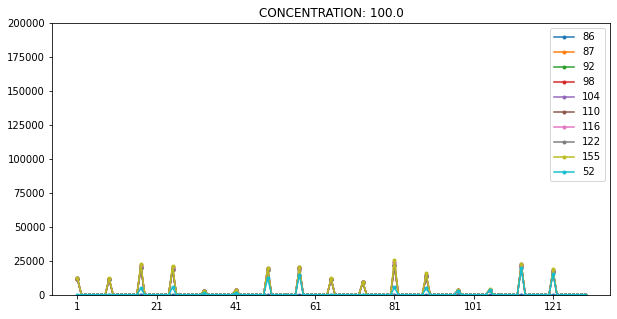

<Figure size 432x288 with 0 Axes>

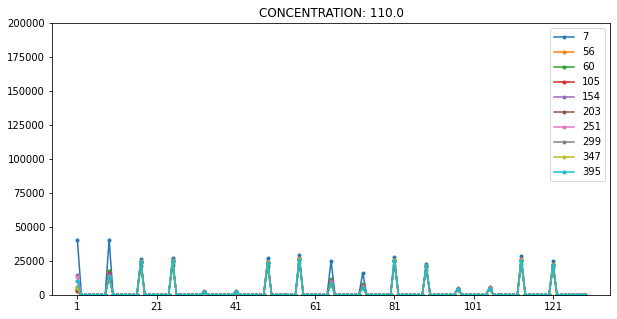

<Figure size 432x288 with 0 Axes>

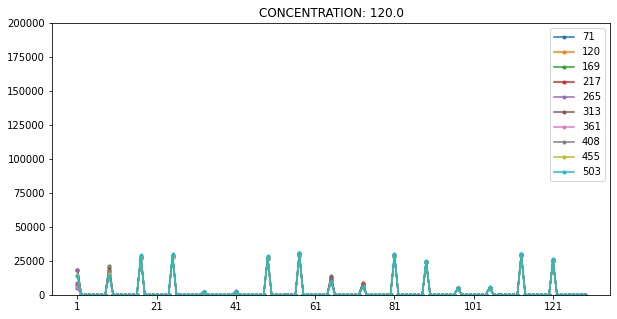

<Figure size 432x288 with 0 Axes>

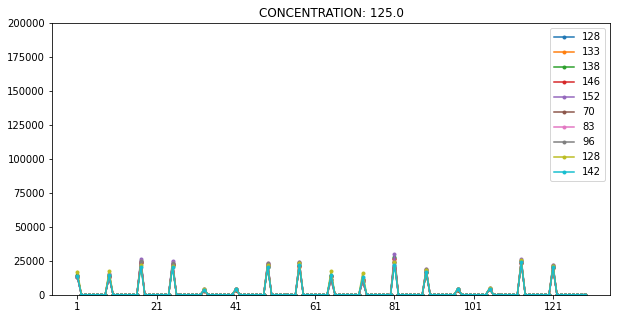

<Figure size 432x288 with 0 Axes>

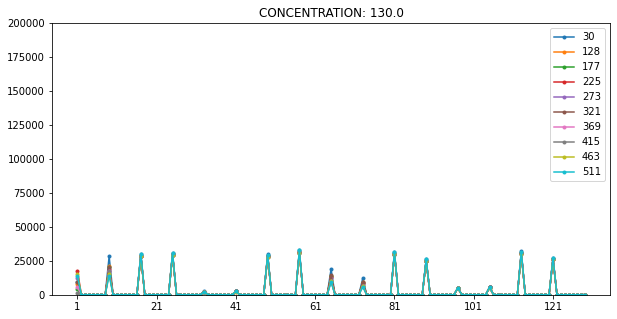

<Figure size 432x288 with 0 Axes>

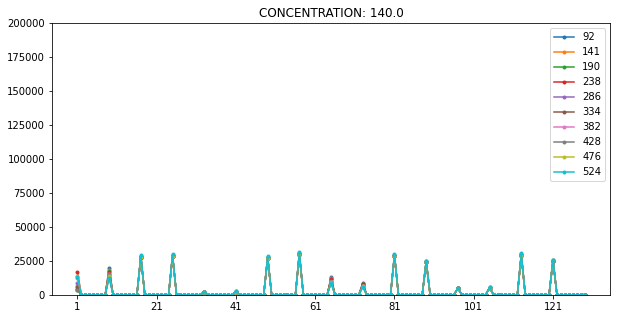

<Figure size 432x288 with 0 Axes>

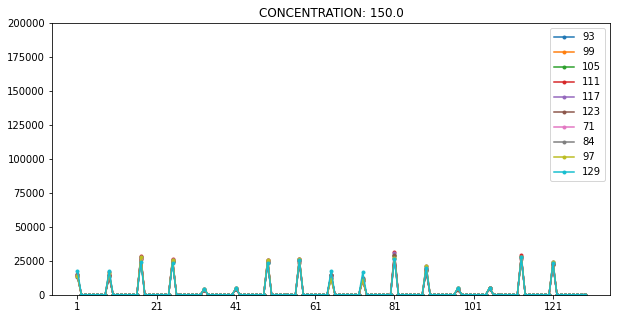

<Figure size 432x288 with 0 Axes>

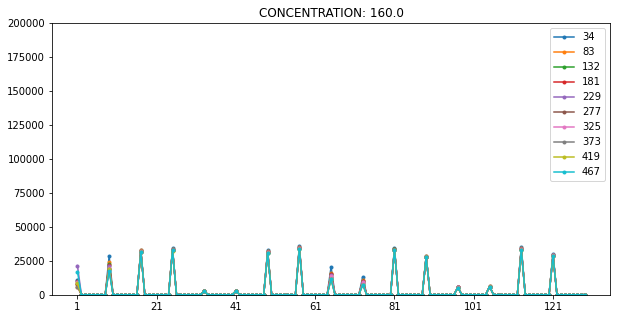

<Figure size 432x288 with 0 Axes>

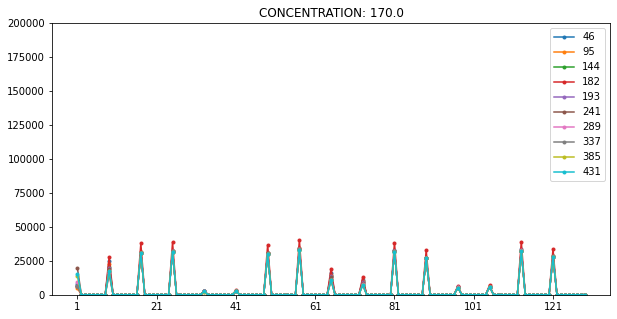

<Figure size 432x288 with 0 Axes>

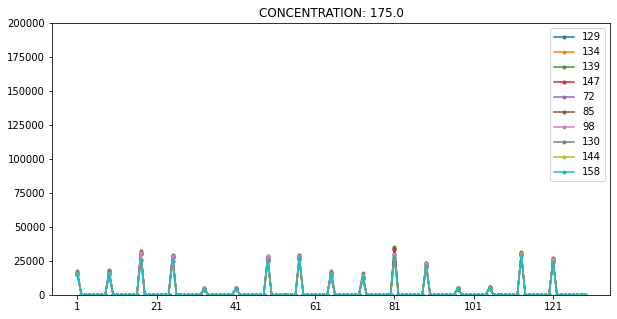

<Figure size 432x288 with 0 Axes>

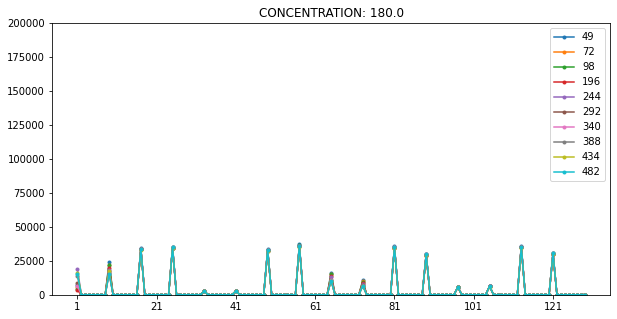

<Figure size 432x288 with 0 Axes>

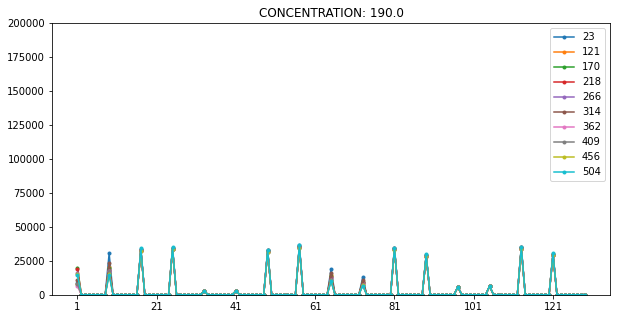

<Figure size 432x288 with 0 Axes>

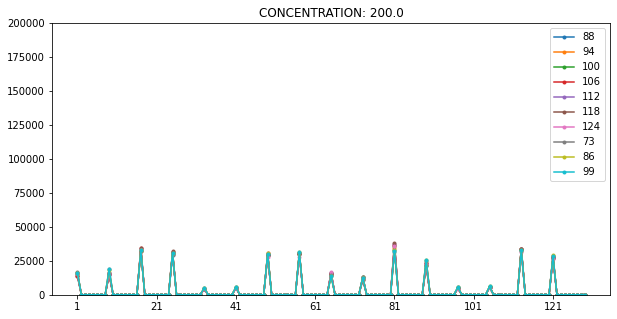

<Figure size 432x288 with 0 Axes>

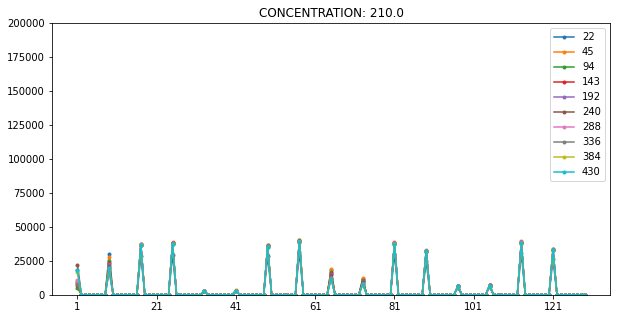

<Figure size 432x288 with 0 Axes>

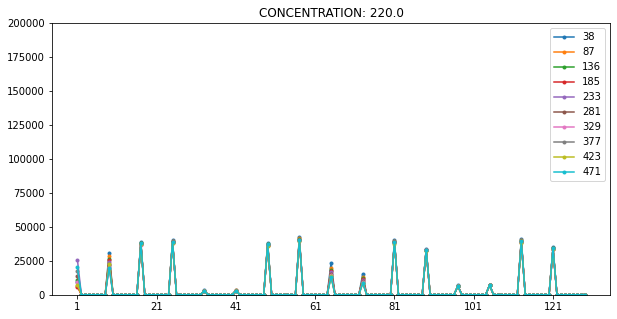

<Figure size 432x288 with 0 Axes>

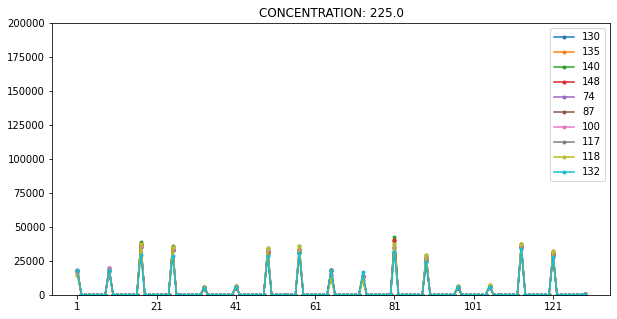

<Figure size 432x288 with 0 Axes>

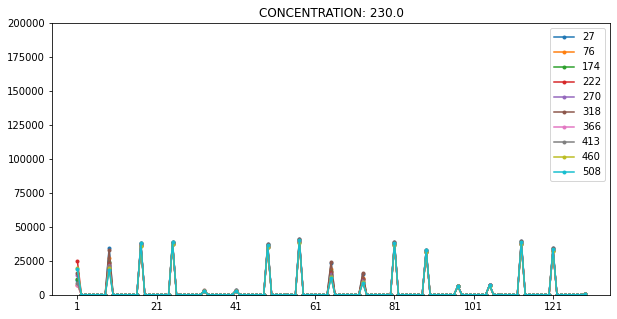

<Figure size 432x288 with 0 Axes>

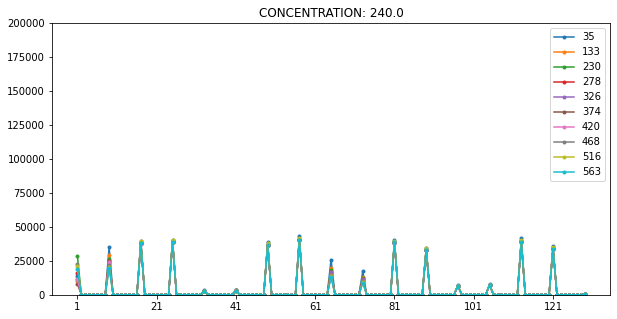

<Figure size 432x288 with 0 Axes>

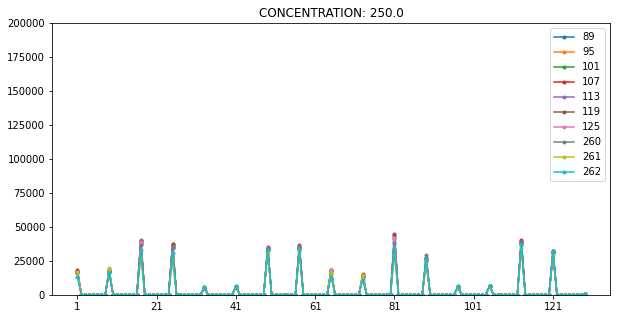

<Figure size 432x288 with 0 Axes>

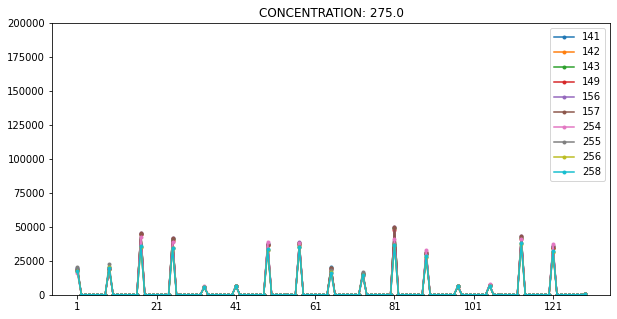

<Figure size 432x288 with 0 Axes>

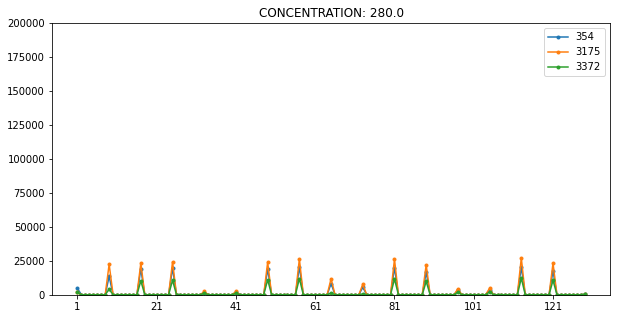

<Figure size 432x288 with 0 Axes>

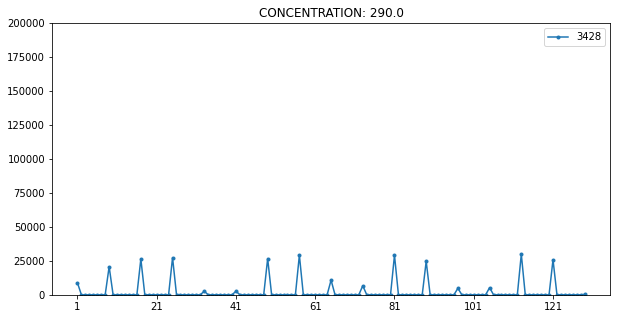

<Figure size 432x288 with 0 Axes>

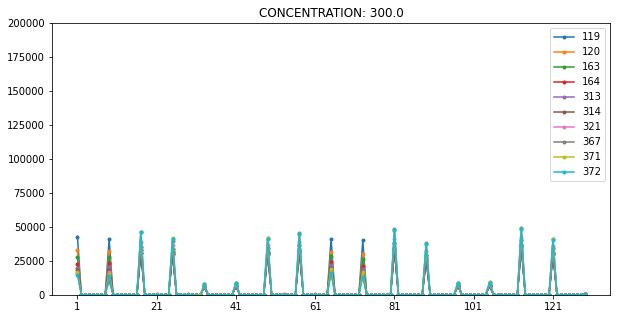

In [74]:
for val in np.sort(df_signal['CONCENTRATION'].unique()):
  df_plot = df_signal[df_signal['CONCENTRATION']==val]
  plt.figure()
  df_plot.T.iloc[:,:10].plot(figsize=(10,5), style = '.-')
  plt.ylim([0, 200_000])
  plt.title('CONCENTRATION: ' + str(val))

In [75]:
df_signal.T.iloc[:,:10]

,84,85,86,87,88,89,90,91,92,93
1,3115.218700,9056.404300,-518.410100,11840.933600,13599.617100,17165.783200,2500.093800,8762.287100,11700.587900,13078.871100
2,1.144049,1.428937,0.975693,1.570923,1.589595,1.762422,1.110661,1.376022,1.472016,1.508245
3,0.725879,2.588769,3.553487,3.078159,3.995321,4.380791,0.383144,1.902307,2.916336,3.469116
4,0.892731,3.392774,4.982443,4.167200,6.187752,7.159065,0.561727,2.697927,4.678075,5.441586
5,2.289280,4.306132,6.105124,4.810006,7.275471,8.179185,2.486117,3.636703,5.767297,6.649036
...,...,...,...,...,...,...,...,...,...,...
125,1.195833,5.564010,11.871335,11.654879,18.405247,19.787953,1.427403,6.519315,11.816688,15.709908
126,-0.764849,-3.049120,-0.016275,-4.665714,-7.787530,-9.144154,-0.750537,-2.786693,-4.617763,-6.362538
127,-1.163802,-4.741565,-0.062814,-7.480605,-12.765952,-15.266672,-1.104477,-4.415990,-7.495574,-10.935900
128,-1.468700,-5.263950,-0.528959,-8.019985,-13.719466,-16.491284,-1.612768,-4.939460,-8.263003,-11.847542


In [76]:
df_signal2 = df_signal.set_index('CONCENTRATION')
df_signal2

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128
CONCENTRATION,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
10.0,3115.2187,1.144049,0.725879,0.892731,2.289280,-0.653573,-0.880368,-2.250219,3141.8360,1.143472,0.684645,0.869567,2.017089,-0.578139,-0.798202,-2.011773,4323.2023,3.383513,0.662719,0.793653,1.543981,-0.695214,-1.048555,-1.743617,4045.1617,3.312601,0.615651,0.742646,1.095635,-0.658878,-0.943849,-1.323416,646.8947,1.604309,0.125030,0.171400,0.601860,-0.144453,-0.251990,-0.556112,...,2825.1401,3.367511,0.454819,0.572504,1.378579,-0.498622,-0.713742,-0.968787,728.5904,1.644178,0.144673,0.209313,1.560374,-0.164896,-0.279549,-0.683613,908.8643,1.731024,0.178005,0.246167,0.923906,-0.197550,-0.316453,-0.831943,4717.8947,4.688191,0.789802,0.979917,1.412198,-0.913870,-1.388484,-1.784168,3968.7595,4.512079,0.677803,0.829486,1.195833,-0.764849,-1.163802,-1.468700
50.0,9056.4043,1.428937,2.588769,3.392774,4.306132,-1.865373,-2.373295,-3.354903,8520.1739,1.388514,2.335484,3.063151,4.058828,-1.711644,-2.170848,-3.242873,13104.0967,7.277147,3.176058,4.369131,4.749466,-2.917124,-4.170908,-4.731144,12184.6846,7.093771,2.929176,4.065813,4.500087,-2.732807,-3.933304,-4.488820,1990.2982,2.830916,0.560703,0.883610,1.242983,-0.521488,-0.845745,-1.228657,...,8541.4948,7.265501,2.103707,2.927536,3.328059,-2.002209,-2.850905,-3.432855,2173.2374,2.875196,0.637683,1.128929,1.469001,-0.593501,-1.067354,-1.387080,2640.6903,3.063679,0.753474,1.233114,1.652711,-0.688824,-1.088053,-1.543262,14286.2177,10.073236,4.052377,6.123930,6.649247,-3.807336,-6.417218,-7.028767,11744.5761,9.472424,3.310410,5.012727,5.564010,-3.049120,-4.741565,-5.263950
100.0,-518.4101,0.975693,3.553487,4.982443,6.105124,-0.029429,-0.261390,-2.523801,-40.1308,0.998182,3.284800,4.478893,6.269287,-0.030983,-0.330941,-1.431367,185.4209,1.082758,5.965761,9.345064,10.005833,-0.029120,-0.163975,-0.575392,166.7058,1.077721,5.531181,8.839491,9.389405,-0.023195,-0.119072,-0.614390,0.6032,1.000542,0.988494,1.766269,2.145798,-0.009882,-0.098356,-0.506055,...,93.0062,1.063354,3.926317,6.123409,6.522851,-0.017038,-0.122852,-0.622988,1.8327,1.001548,1.154438,2.219856,2.845502,-0.012079,-0.119042,-0.976133,14.8005,1.011301,1.314624,2.399152,3.025287,-0.011510,-0.090792,-0.719490,138.4607,1.080908,8.094369,13.887499,14.825709,-0.022472,-0.136892,-0.372947,114.5632,1.076385,6.370201,10.859625,11.871335,-0.016275,-0.062814,-0.528959
100.0,11840.9336,1.570923,3.078159,4.167200,4.810006,-2.412149,-2.969277,-4.085392,11270.4942,1.513499,2.760452,3.860618,6.427276,-2.266611,-2.796435,-3.873928,19936.2029,9.988898,5.565531,8.652145,9.192730,-4.840228,-6.946785,-7.541631,18298.3101,9.653647,5.137007,8.275946,9.039640,-4.457584,-6.460786,-7.001097,2834.2052,3.572164,0.895545,1.739390,2.165162,-0.778953,-1.236122,-1.584968,...,12864.0846,9.858237,3.677908,5.754964,6.298603,-3.243453,-4.683117,-5.221767,3073.3055,3.615640,1.028086,2.318225,2.767312,-0.881566,-1.506382,-1.826682,3699.1553,3.835671,1.194412,2.423496,3.054797,-1.014298,-1.603026,-2.004500,20798.7208,13.367539,7.317229,13.352479,14.496068,-5.841395,-10.102973,-11.141285,17052.1697,12.484829,5.866178,10.628155,11.654879,-4.665714,-7.480605,-8.019985
200.0,13599.6171,1.589595,3.995321,6.187752,7.275471,-3.043441,-3.678293,-5.029004,14566.1504,1.629697,3.704878,5.482704,6.465528,-3.018466,-3.782230,-5.167700,32590.1824,16.591865,8.250844,13.419895,14.344594,-8.586110,-12.533508,-13.335736,29601.5760,15.561237,7.609507,13.089466,14.594686,-7.885902,-11.732270,-12.586488,4388.9784,5.031573,1.220946,2.802131,3.472193,-1.286002,-2.078712,-2.608872,...,21358.0096,16.473379,5.463761,9.052317,9.842958,-5.757556,-8.424376,-9.134358,4741.5793,5.018095,1.402588,3.668575,4.564300,-1.471223,-2.634461,-3.2232

In [84]:
df_in = df_signal.groupby(by = 'CONCENTRATION').mean()
df_in

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128
CONCENTRATION,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1.0,1852.392984,1.392755,1.736916,3.030608,6.047586,-0.441585,-1.007792,-6.002219,2595.695123,1.541477,2.972718,5.386519,9.038668,-0.548355,-1.236821,-7.445201,-77.868094,0.966005,0.456278,1.261657,3.986828,-0.139624,-0.469139,-3.480321,-77.503976,0.968160,0.468966,1.282964,4.002240,-0.142540,-0.471979,-3.454514,95.799709,1.069690,0.442028,1.411698,3.646157,-0.082546,-0.375330,-2.968112,...,-119.376148,0.956946,0.431552,1.233550,4.468213,-0.144704,-0.495631,-3.771498,146.541755,1.107274,0.491896,1.622404,4.682594,-0.095603,-0.436754,-3.559798,141.437353,1.105543,0.460523,1.477920,4.426648,-0.090558,-0.420558,-3.465688,43.597814,1.009958,0.865100,2.421991,5.801416,-0.202468,-0.588862,-4.012805,66.985062,1.019293,0.828507,2.364152,5.533352,-0.184587,-0.543036,-3.650937
2.5,1164.519980,1.294471,0.655055,1.432967,4.173760,-0.271994,-0.653377,-4.090007,7317.505780,1.793457,5.020337,10.254788,17.863149,-1.544094,-2.678972,-11.637664,719.167127,1.170258,0.701255,1.712088,5.067023,-0.258785,-0.711457,-4.958819,771.831687,1.171102,0.725833,1.784408,5.281743,-0.267177,-0.717649,-4.918326,429.333967,1.238918,0.411048,1.358050,3.940931,-0.130223,-0.473973,-3.678841,...,809.471480,1.173926,0.735962,1.696075,4.135969,-0.268587,-0.571879,-3.245325,712.345847,1.308187,0.663957,2.134210,4.266023,-0.178487,-0.457546,-2.694331,692.231760,1.303445,0.638967,1.957607,4.086434,-0.172266,-0.427169,-2.657981,1206.438627,1.208123,1.253947,3.224201,5.984834,-0.374108,-0.738577,-3.623780,1257.224160,1.238024,1.205071,3.081268,5.778285,-0.358781,-0.697506,-3.536910
5.0,13024.134876,2.939570,2.344211,3.298564,6.516355,-2.017795,-2.761482,-8.019371,20740.658300,3.444070,5.698582,9.678935,15.385240,-3.503625,-5.081686,-15.261515,1056.844538,1.303674,0.798254,1.942819,5.146617,-0.452963,-0.939976,-5.183271,1052.308933,1.299116,0.808858,1.938557,5.273377,-0.468238,-0.948120,-5.188116,627.836814,1.399037,0.341866,1.096738,3.147439,-0.170818,-0.490439,-3.178352,...,1700.131743,1.466605,0.834864,1.827616,4.022904,-0.444247,-0.757876,-3.232857,1051.876290,1.515998,0.578488,1.855760,3.696863,-0.249990,-0.516080,-2.639201,1050.811505,1.508959,0.587919,1.825585,3.588387,-0.247832,-0.501182,-2.480861,2630.929871,1.625590,1.400172,3.455409,5.863381,-0.600187,-1.030387,-3.660678,2581.635538,1.702908,1.286936,3.112848,5.498200,-0.557359,-0.938242,-3.420160
10.0,13282.774302,2.811189,3.953216,6.677565,10.860011,-2.305702,-3.618868,-11.839109,22570.113871,4.920023,7.810594,14.140308,20.762290,-4.272972,-7.459712,-22.111525,3627.839885,1.831503,1.659024,3.585284,7.387866,-0.937021,-1.665838,-7.143131,3580.166066,1.794198,1.647026,3.484942,7.362411,-0.932942,-1.643707,-7.046338,1615.983353,1.826129,0.812002,2.353945,5.022044,-0.386537,-0.837150,-4.402303,...,4627.626874,2.020020,1.693561,3.344537,5.927172,-0.947195,-1.452343,-4.563589,2157.688789,2.013467,1.057619,3.034642,5.370474,-0.465421,-0.826389,-3.098121,2151.530826,2.001596,1.058186,2.975496,5.129985,-0.461002,-0.806097,-2.943104,6736.781403,2.269548,2.895949,6.922608,10.180651,-1.407022,-2.213309,-5.951195,5974.978293,2.291792,2.545619,6.157782,9.147690,-1.234915,-1.939551,-5.195182
15.0,21031.670554,3.753302,4.871407,6.685567,9.370526,-3.418279,-4.810311,-13.576814,36588.421438,4.811723,9.881946,15.506280,23.029930,-6.670803,-9.795665,-28.825325,2528.816946,1.645703,1.113289,2.353132,6.044194,-0.763838,-1.405464,-6.160935,2576.657077,1.629980,1.141322,2.344318,5.978241,-0.786205,-1.416950,-6.165013,1115.201038,1.657512,0.442336,1.253854,3.495314,-0.290835,-0.654515,-3.419659,...,3755.452231,1.941823,1.218531,2.298112,4.578651,-0.841028,-1.316291,-4.028986,1777.6

In [0]:
for col_name, col_data in df_in.iteritems():
  df_in[col_name] = (col_data - col_data.mean())/col_data.std()

In [79]:
df_in.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128
CONCENTRATION,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2.5,-1.500890,-1.559691,-0.910886,-0.928492,-0.895128,1.348681,1.268106,0.658304,-1.577641,-1.609022,-1.220856,-1.135279,-0.878589,1.409254,1.168459,0.591193,-1.457750,-1.012466,-1.456078,-1.385572,-1.270477,1.524417,1.469082,1.208395,-1.449504,-0.916482,-1.441354,-1.380602,-1.066109,1.517347,1.138681,0.460327,-1.204336,-0.944199,-1.311732,-1.306559,-0.953613,1.193948,1.147536,-0.277129,...,-1.386457,-0.946215,-1.403665,-1.364035,-1.310438,1.502539,1.496683,1.326665,-1.472979,-1.171600,-1.557374,-1.680205,-1.691627,1.503559,1.435664,1.087586,-1.501618,-1.228470,-1.550455,-1.632404,-1.518402,1.542266,1.451218,0.914686,-1.424029,-0.907799,-1.483378,-1.495839,-1.421468,1.499078,1.471213,1.441398,-1.426902,-0.927929,-1.476148,-1.495488,-1.419526,1.504269,1.473719,1.405403
5.0,-1.174686,-1.159163,-0.808032,-0.825292,-0.832164,1.134491,1.137715,0.574555,-0.805753,-1.132972,-0.907792,-0.853514,-0.531383,0.697954,0.570723,0.379135,-1.259126,-0.877193,-1.249448,-1.196024,-1.155639,1.321335,1.277660,1.023130,-1.253541,-0.803413,-1.232296,-1.200019,-0.996937,1.315276,0.983633,0.409746,-0.999316,-0.794748,-1.084198,-1.109502,-1.031956,0.988260,0.924680,0.101136,...,-1.179853,-0.855644,-1.170345,-1.150096,-1.048860,1.286614,1.283503,1.070982,-1.246910,-0.997521,-1.304298,-1.424256,-1.294514,1.298030,1.227557,1.022843,-1.259027,-1.034203,-1.303716,-1.408207,-1.146552,1.322443,1.326576,1.242968,-1.204571,-0.831912,-1.236142,-1.280149,-1.270642,1.290286,1.270279,1.194730,-1.196637,-0.847412,-1.229925,-1.263363,-1.214329,1.291645,1.274753,1.116898
10.0,-1.340556,-1.571497,-0.816150,-0.804718,-0.651812,1.118194,0.978502,0.413648,-1.489730,-1.405192,-1.117101,-1.022502,-0.874719,1.258083,0.895272,0.446983,-2.076875,-1.474763,-1.861980,-1.607812,-1.478263,1.886585,1.828841,1.589750,-2.107504,-1.323680,-1.849529,-1.612261,-1.242905,1.892458,1.393873,0.614610,-1.433321,-1.099996,-1.483730,-1.484158,-1.157792,1.253819,1.181487,0.299084,...,-2.111939,-1.378141,-1.888703,-1.642319,-1.508321,1.917368,1.878436,1.671689,-2.001613,-1.526715,-1.905380,-1.873131,-1.520814,1.773419,1.611636,0.834913,-2.034273,-1.600417,-1.912182,-1.830515,-1.502771,1.825152,1.692460,0.937841,-2.113716,-1.229641,-1.920842,-1.726839,-1.601354,1.866544,1.772568,1.724588,-2.121000,-1.232863,-1.926300,-1.739003,-1.617493,1.881590,1.805156,1.744221
20.0,-1.121225,-1.543714,-0.784057,-0.803146,-1.201583,1.115793,1.101461,0.691787,-1.591730,-1.712556,-1.255936,-1.206540,-1.367510,1.530783,1.371709,0.857650,-1.700853,-0.856081,-1.680341,-1.530833,-1.553406,1.655620,1.687545,1.836953,-1.760396,-0.779196,-1.690177,-1.542512,-1.289438,1.681910,1.295770,0.669502,-1.079401,-0.583817,-1.212858,-1.337287,-1.914311,1.012781,1.230532,2.315532,...,-1.780863,-0.768269,-1.712229,-1.556360,-1.576424,1.693883,1.718851,1.878122,-1.671541,-1.024212,-1.695050,-1.739274,-1.952688,1.555745,1.560677,2.267418,-1.683843,-1.103436,-1.689489,-1.705805,-1.866544,1.584565,1.622147,2.282181,-1.730041,-0.506162,-1.711447,-1.623803,-1.598422,1.597062,1.555286,1.794503,-1.737258,-0.502596,-1.708399,-1.628877,-1.619122,1.613242,1.593177,1.855930
25.0,-1.437201,-1.323139,-0.924079,-1.003092,-1.642734,1.437069,1.445273,0.865530,-1.764106,-1.464159,-1.329710,-1.281640,-1.654107,1.677313,1.525011,0.987604,-1.220146,-0.957167,-1.010559,-0.953597,-1.093037,1.193512,1.304405,1.757062,-1.259713,-0.881668,-1.015281,-0.936992,-0.931021,1.212251,1.017445,0.662519,-0.755776,-0.795299,-0.268643,0.131058,-0.472751,0.730190,1.061616,2.711496,...,-1.257351,-0.819420,-1.008041,-0.895505,-0.995389,1.189859,1.263380,1.639757,-1.024199,-0.970230,-0.580400,-0.038042,-0.222928,0.988

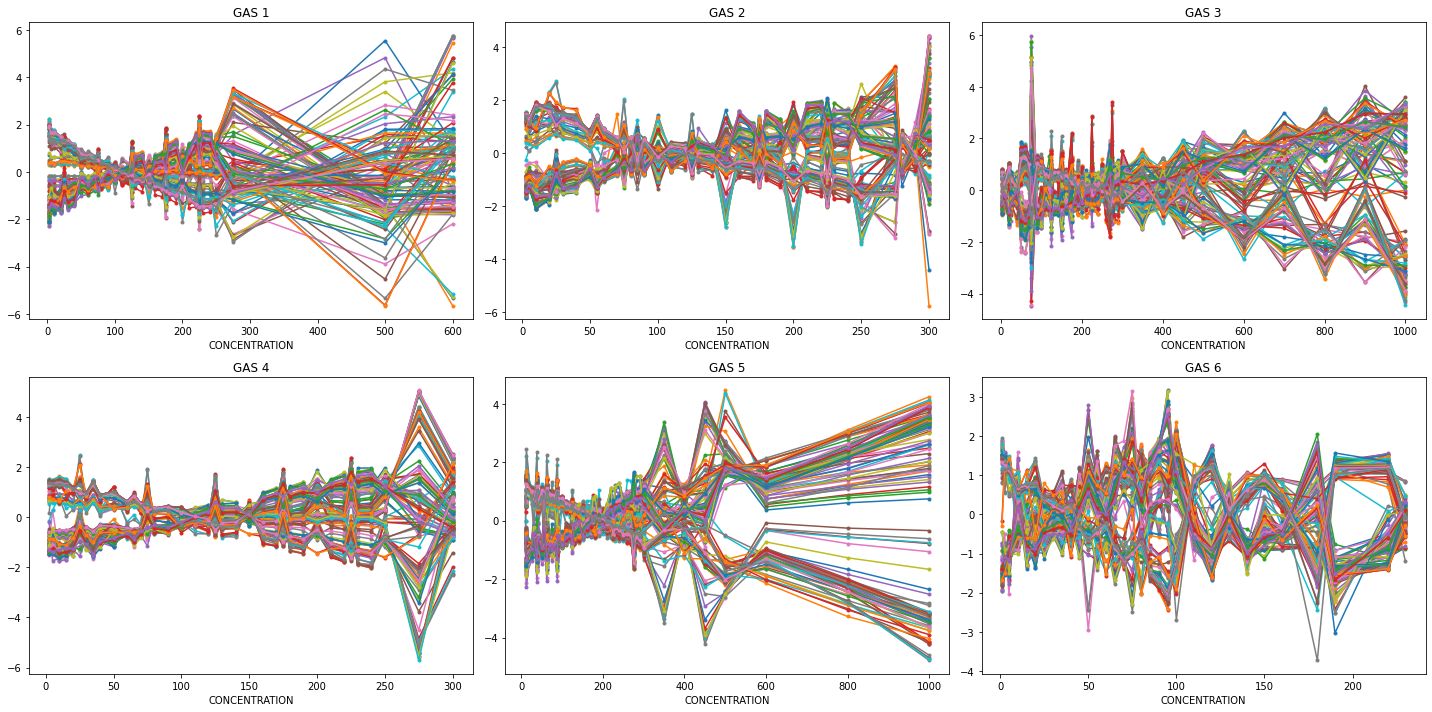

In [80]:
fig, axes = plt.subplots(2,3)
axes = axes.flatten()
for gas, ax in zip(range(1,7,1), axes):
  df_gas = GasDataFrame(df).df
  # Selecciono el gas
  df_gas_1 = df_gas[df_gas['GAS']==gas]
  df_signal = df_gas_1.drop(columns = ['GAS', 'Batch ID'])
  
  #Agrupo las señales por concentracion y calculo su media
  df_in = df_signal.groupby(by = 'CONCENTRATION').mean()

  # Estandarizo cada concentracion
  for col_name, col_data in df_in.iteritems():
    df_in[col_name] = (col_data - col_data.mean())/col_data.std()

  # Represento el grafico
  ax = df_in.plot(figsize=(20,10), style='.-', ax=ax)
  ax.legend().remove()
  ax.title.set_text('GAS ' + str(gas))
fig.tight_layout()

In [0]:
def concentration_plot(ax, df_gas, gas=1):
  df = df_gas.copy()
  df_signal = df[df['GAS'] == gas]
  df_signal = df_signal.drop(columns = ['GAS', 'Batch ID'])
  df_in = df_signal.groupby(by = 'CONCENTRATION')
  ax = df_in.mean().plot(style='.-', ax=ax)
  ax.get_legend().remove()
  ax.title.set_text('GAS ' + str(gas))

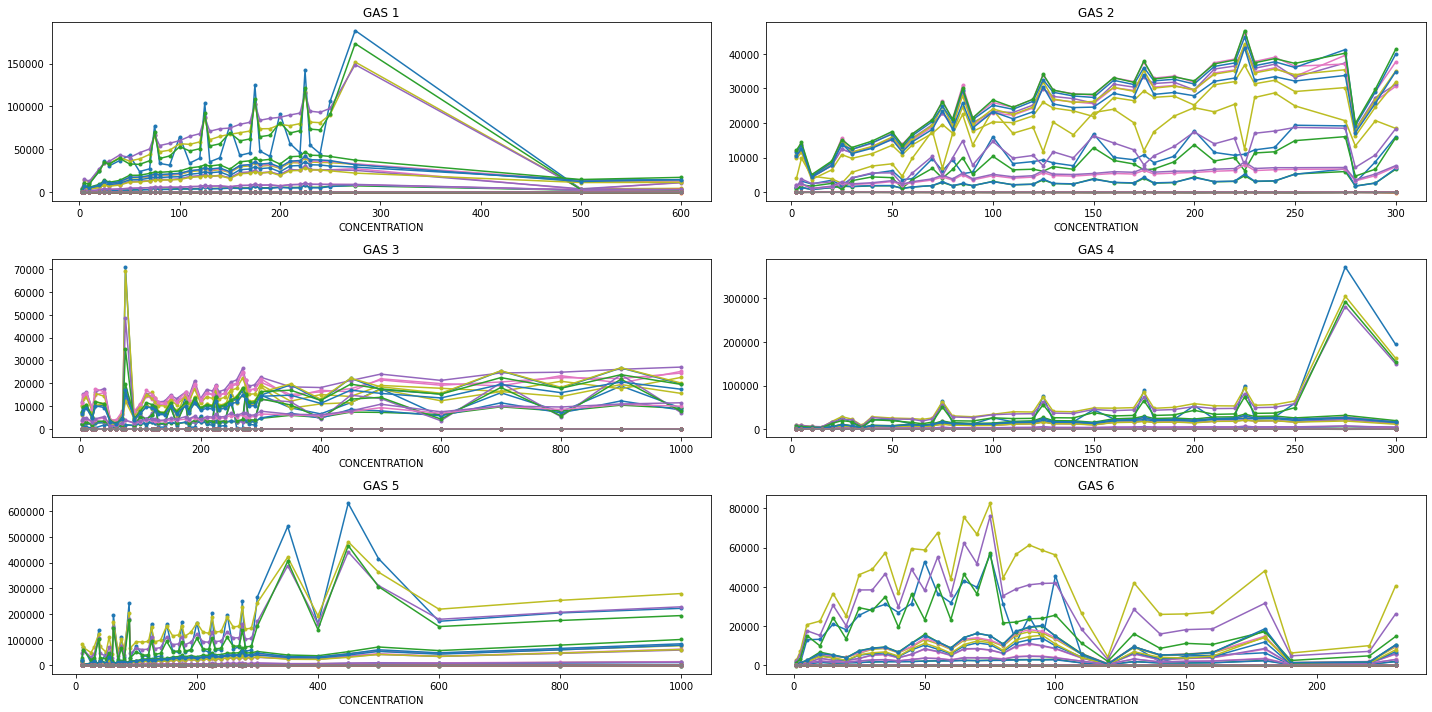

In [82]:
fig, axes = plt.subplots(3, 2, figsize=(20,10))

for i, ax in enumerate(axes.flatten()):
  concentration_plot(ax, df_gas, gas=i+1)
plt.tight_layout()

1
2
3
4
5
6


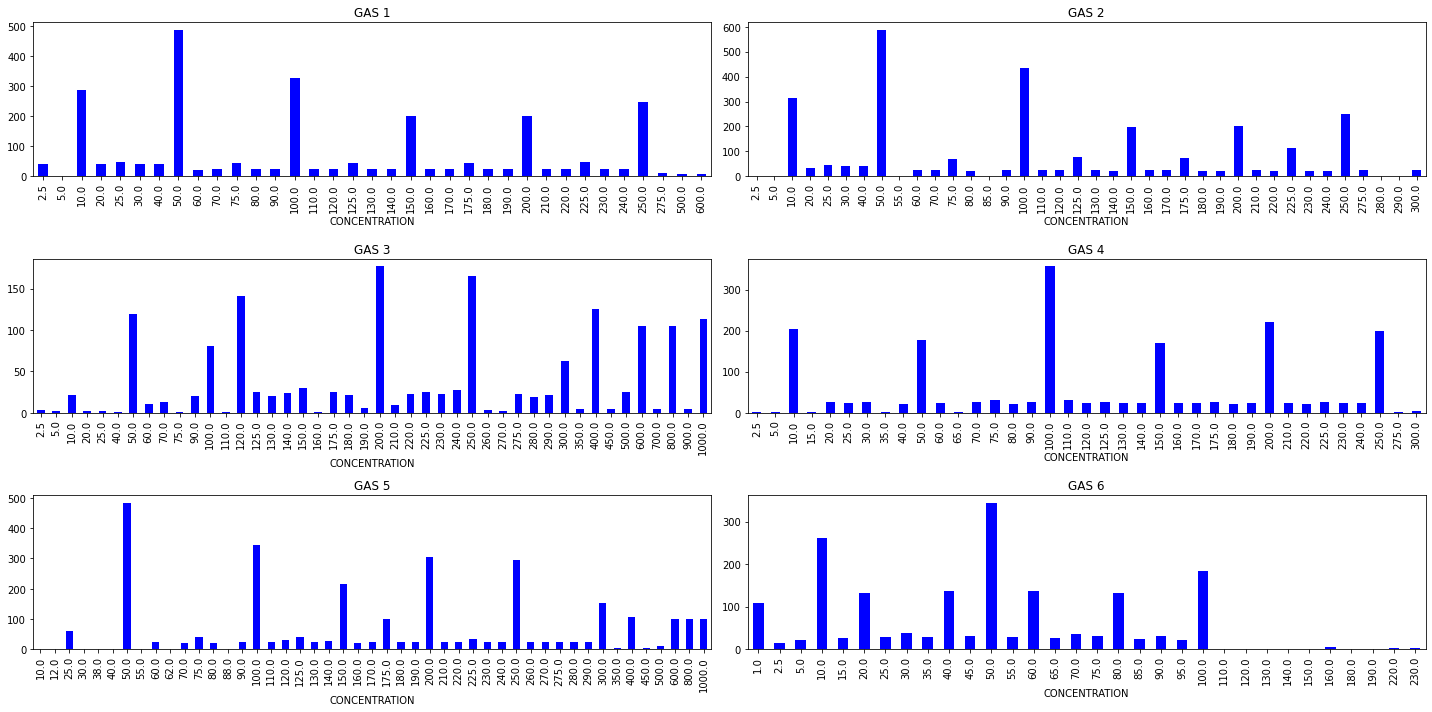

In [89]:
def concentration_plot_count(ax, df_gas, gas=1):
  df = df_gas.copy()
  df_signal = df[df['GAS'] == gas]
  df_signal = df_signal.drop(columns = ['GAS', 'Batch ID'])
  df_in = df_signal.groupby(by = 'CONCENTRATION')

  #ax = df_in.count().plot(style='.-', ax=ax, color='b')
  ax = df_in.count().plot.bar(ax=ax, color='blue')
  ax.get_legend().remove()
  ax.title.set_text('GAS ' + str(gas))

fig, axes = plt.subplots(3, 2, figsize=(20,10))

for i, ax in enumerate(axes.flatten(), start=1):
  print(i)
  concentration_plot_count(ax, df_gas, gas=i)
plt.tight_layout()